# Visualize model parameters

this notebook helps with visualizing stcnn model training by plotting losses and model parameters saved in each model checkpoint

In [1]:
import sys
sys.path.append('..')

import os
import torch
import torch.nn.functional as F
import numpy as np
import math

from stcnn.ca_dataloader import LCDataLoader, load_ca_data, load_vstim_mov
from stcnn.model_factory import model_stcnn_factory
from stcnn.util_analysis import plot_spatial_kernels, plot_weight_hist, plot_loss_history  

import pickle

from pathlib import Path
import matplotlib.pyplot as plt

from celluloid import Camera

from natsort import natsorted

import json

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    dev_cnt = torch.cuda.device_count()
    print(f'CUDA version {torch.version.cuda}')
    my_device = torch.device('cuda:' + str(dev_cnt-1) )  
else:
    my_device = torch.device('cpu')

print(my_device)

Quadro RTX 5000
CUDA version 10.2
cuda:1


## Define file paths for model config and checkpoints

this code assumes the model training
- model config and checkpoints are saved in a common folder
- checkpoints have a common prefix and suffix naming scheme
- a checkpoint is saved after every training epoch

note that checkpoint 0 is the model initialization before any training

In [3]:
cwd_path = Path.cwd()

# setup path containing model training checkpoints
base_path = cwd_path.parent
expt_dir = 'experiments'
trained_model_dir = 'lc_small_3'

model_dir = base_path / expt_dir / trained_model_dir
fname_prefix = 'model_'
fname_suffix = '.pt'

model_config = 'config.json'

In [4]:
# load model configuration
with open( model_dir / model_config) as f:
    config = json.load(f)

print(config.keys())    

dict_keys(['experiment_path', 'pr_config', 'network_config', 'L_config', 'ca_config', 'data_count', 'sampling_rate', 'dataset_config'])


In [5]:
# search for checkpoint files
chkpnt_fnames = [str(f.name) for f in os.scandir(model_dir) if f.name.startswith(fname_prefix) and f.name.endswith(fname_suffix) and f.is_file()]
chkpnt_fnames = natsorted(chkpnt_fnames)

chkpnt_fnames

['model_chkpnt_0.pt',
 'model_chkpnt_1.pt',
 'model_chkpnt_2.pt',
 'model_chkpnt_3.pt',
 'model_chkpnt_4.pt',
 'model_chkpnt_5.pt',
 'model_chkpnt_6.pt',
 'model_chkpnt_7.pt',
 'model_chkpnt_8.pt',
 'model_chkpnt_9.pt',
 'model_chkpnt_10.pt']

In [6]:
# setup path for saving analysis
output_dir = model_dir / 'analysis'
Path(output_dir).mkdir(parents=True, exist_ok=True)

## Plot loss history by cell type

losses are saved by celltypes for each training iteration within an epoch  
an epoch is defined as going through every training dataset example once  

- top plot shows the raw losses
- bottom plot shows the rolling window average loss

In [7]:
# show training data count for various celltypes
config['data_count']

{'lc11': 2060, 'lc18': 4751, 'lc17': 3990, 'lc12': 2060, 'lc21': 1442}

In [8]:
loss_hist_logfile = model_dir / 'avg_loss_hist.pkl'

In [9]:
loss_hist = pickle.load( open(loss_hist_logfile, 'rb'  ) )
num_epochs = len(chkpnt_fnames) - 1

(0.001, 0.1)

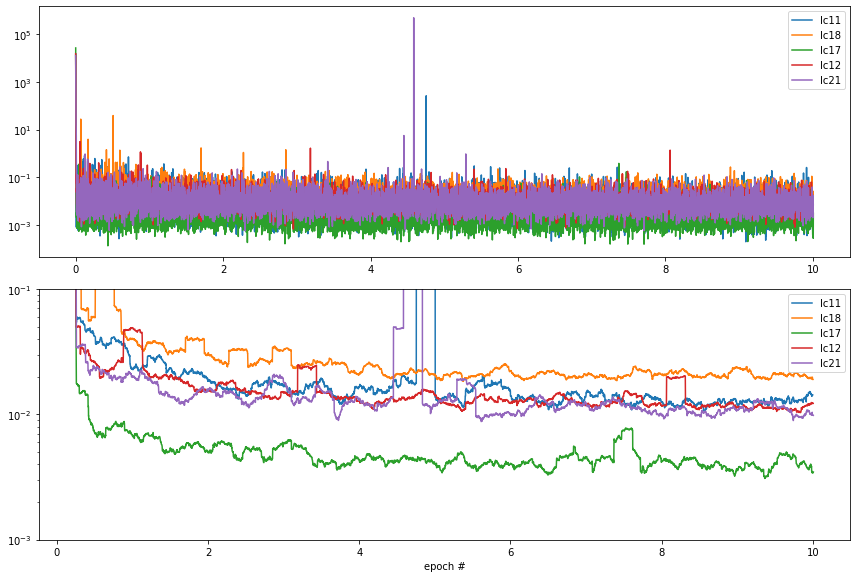

In [10]:
plot_loss_history(loss_hist, num_epochs, output_dir, 'training')
plt.gca().set_ylim(1e-3, 1e-1)

## Load model

In [11]:
model = model_stcnn_factory(config['pr_config'],
                            config['network_config'], 
                            config['L_config'], 
                            config['ca_config'],
                            config['sampling_rate'],
                            my_device)

model.to(my_device)

model.eval() # switch to evaulation mode, applies to layers like batchnorm (to not update running average)

print(model)

LCModelBatchnorm(
  (ca_param): ModuleDict(
    (lc11): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc18): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 19 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 19 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc17): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc12): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
   

## Option to examine individual parameters

In [12]:
# print a list of trained parameters name and tensor size

for name, param in model.named_parameters():
    print(name, param.data.size())

global_ca_tau torch.Size([1])
ca_param.lc11.alpha torch.Size([10])
ca_param.lc11.beta torch.Size([10])
ca_param.lc11.ca_tau torch.Size([1])
ca_param.lc18.alpha torch.Size([19])
ca_param.lc18.beta torch.Size([19])
ca_param.lc18.ca_tau torch.Size([1])
ca_param.lc17.alpha torch.Size([20])
ca_param.lc17.beta torch.Size([20])
ca_param.lc17.ca_tau torch.Size([1])
ca_param.lc12.alpha torch.Size([10])
ca_param.lc12.beta torch.Size([10])
ca_param.lc12.ca_tau torch.Size([1])
ca_param.lc21.alpha torch.Size([7])
ca_param.lc21.beta torch.Size([7])
ca_param.lc21.ca_tau torch.Size([1])
pr.x_weight torch.Size([1, 1, 35, 35])
network.0.x_weight torch.Size([10, 1, 7, 7])
network.0.tau torch.Size([10, 1])
network.0.bias torch.Size([10])
network.1.x_weight torch.Size([10, 10, 7, 7])
network.1.tau torch.Size([10, 1])
network.1.bias torch.Size([10])
network.2.x_weight torch.Size([10, 10, 7, 7])
network.2.tau torch.Size([10, 1])
network.2.bias torch.Size([10])
network.3.x_weight torch.Size([10, 10, 7, 7])
ne

In [13]:
# can directly access any of the above parameters

for f in chkpnt_fnames:
    checkpoint = torch.load(model_dir / f, map_location=my_device)
    model.load_state_dict( checkpoint['model'] )

    print(model.lc_layers[0].tau)

Parameter containing:
tensor([[0.0234]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0212]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0150]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0137]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0133]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0100]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0098]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0099]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0102]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0098]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.0105]], device='cuda:1', requires_grad=True)


## Visualize spatial and temporal weights in model checkpoints

- outputs are saved in the "output_dir" defined above
- spatial weights are plotted and saved by layer in the network  
- individual plots are named as layername_outputchannel_inputchannel

In [14]:
# user options

step_size = 5 # iterate through every step_size file, can be 1 or higher integer

# parameter matching following substring patterns will be plotted as histograms
ptn_match = ['.x_weight', '.tau', '.bias']

fig_scale = 2.5
num_bins = 20 # for histogram

/groups/card/home/klapoetken/optic_nn_modeling/notebooks/../stcnn/util_analysis.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(num_out_ch, num_in_ch, squeeze=False)


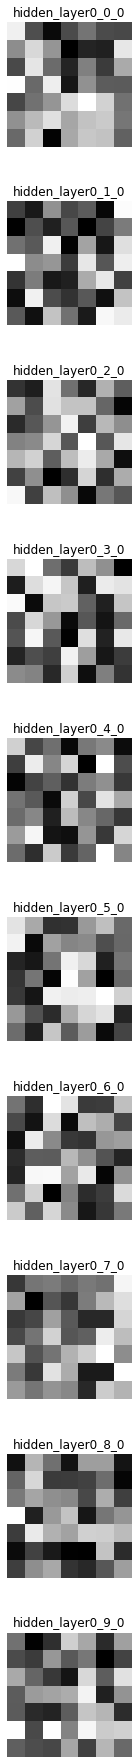

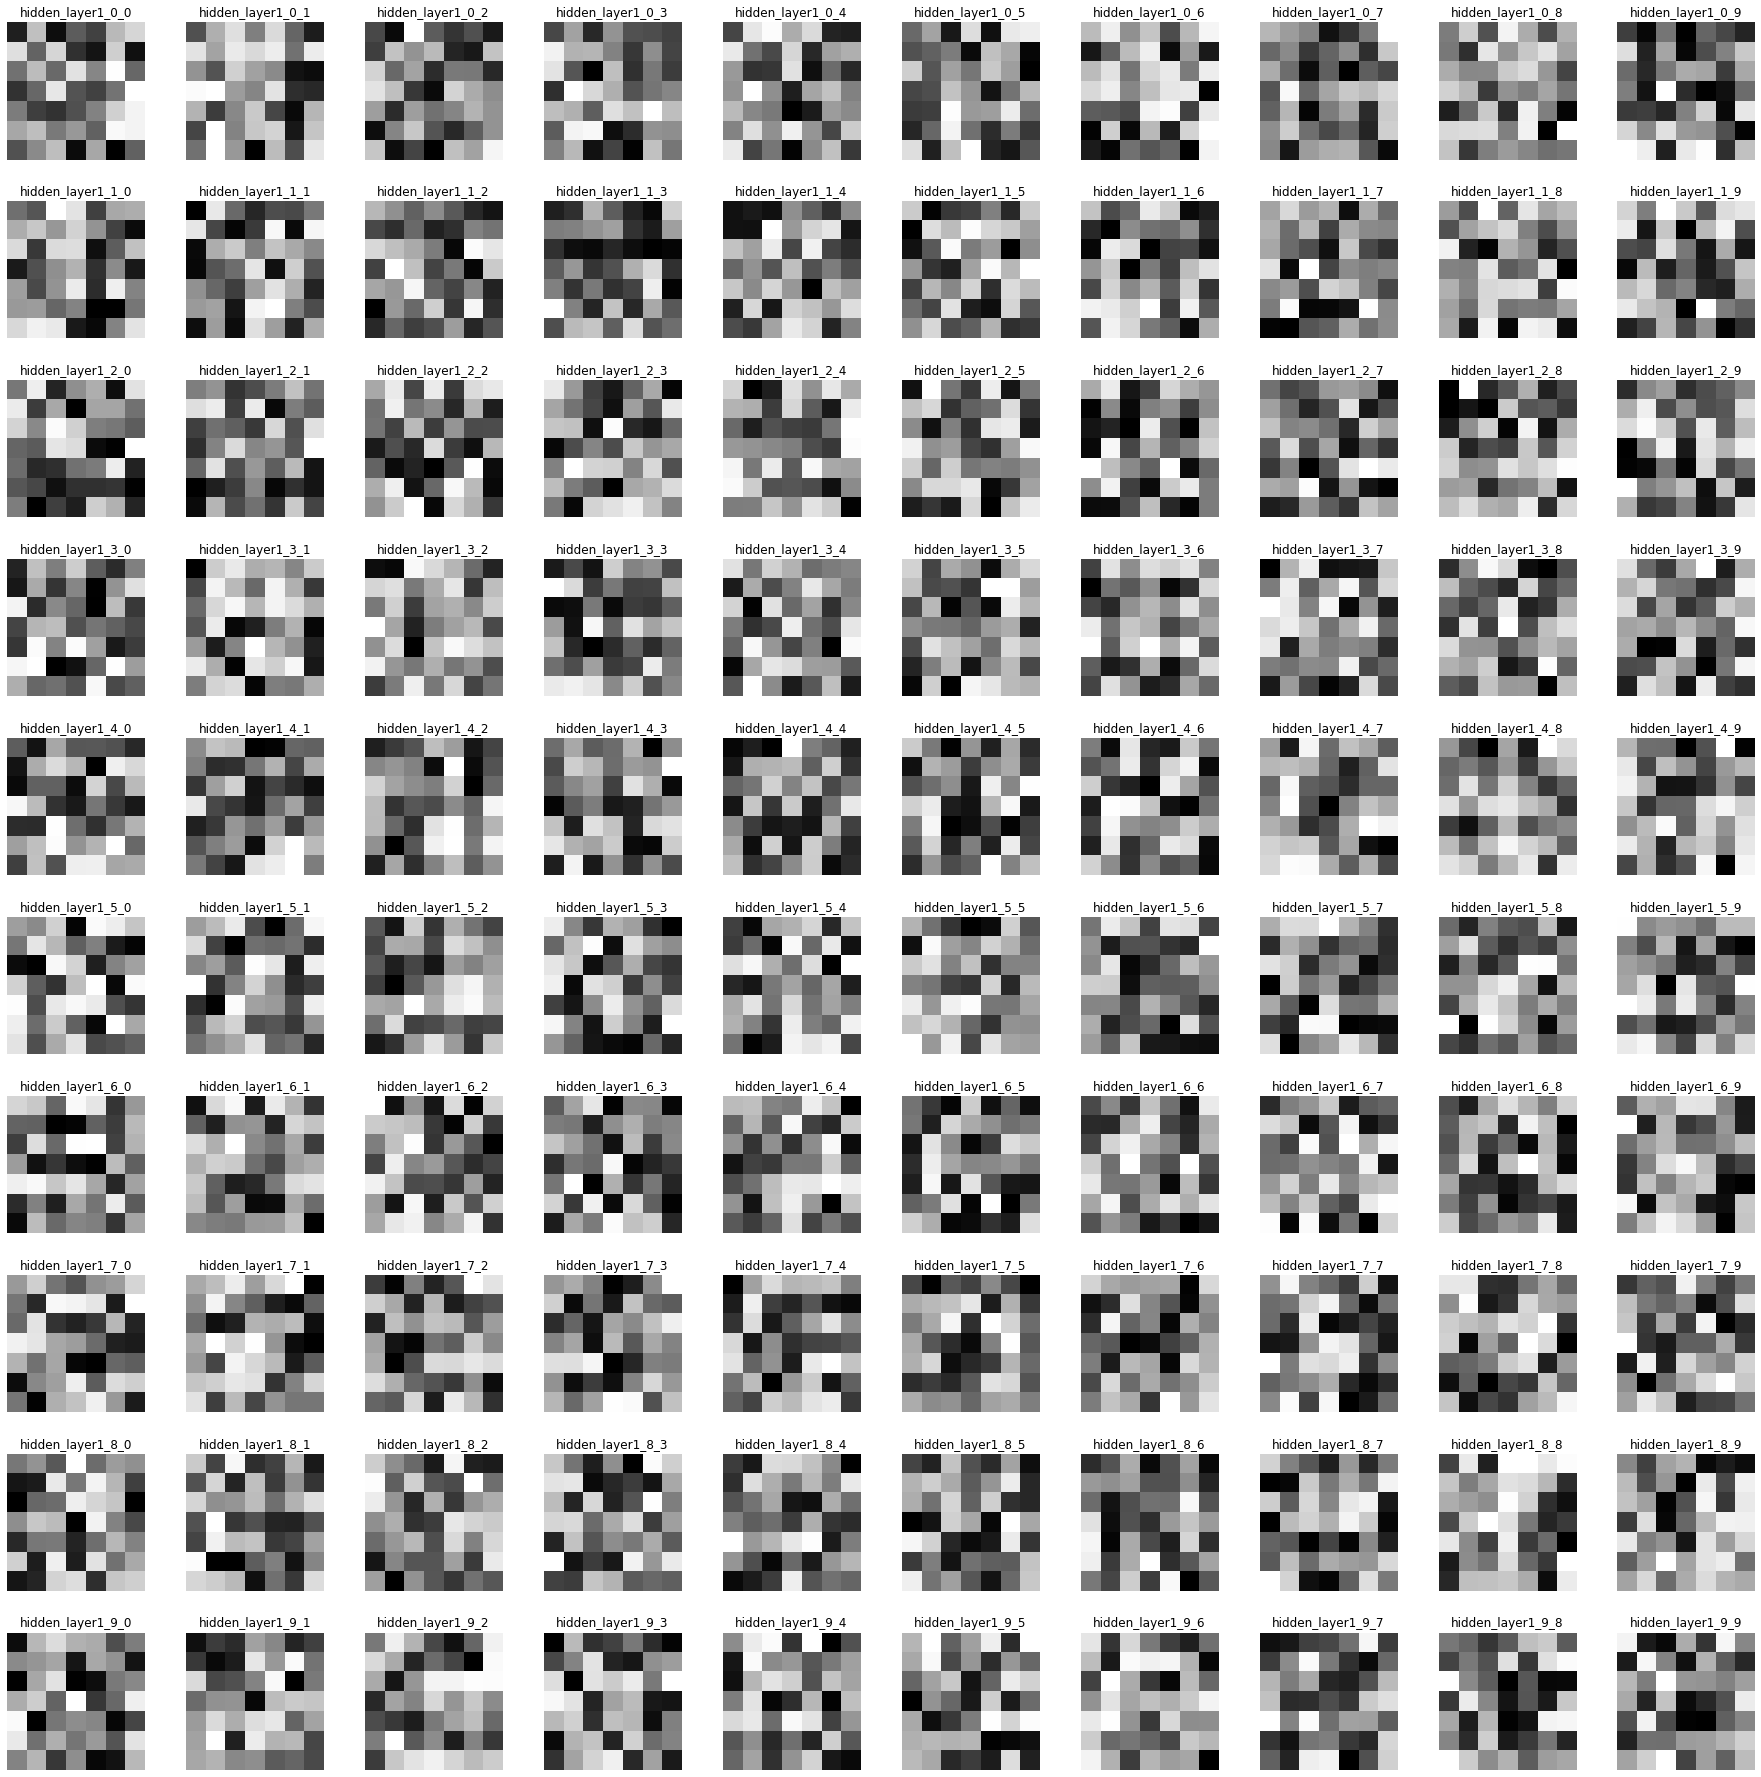

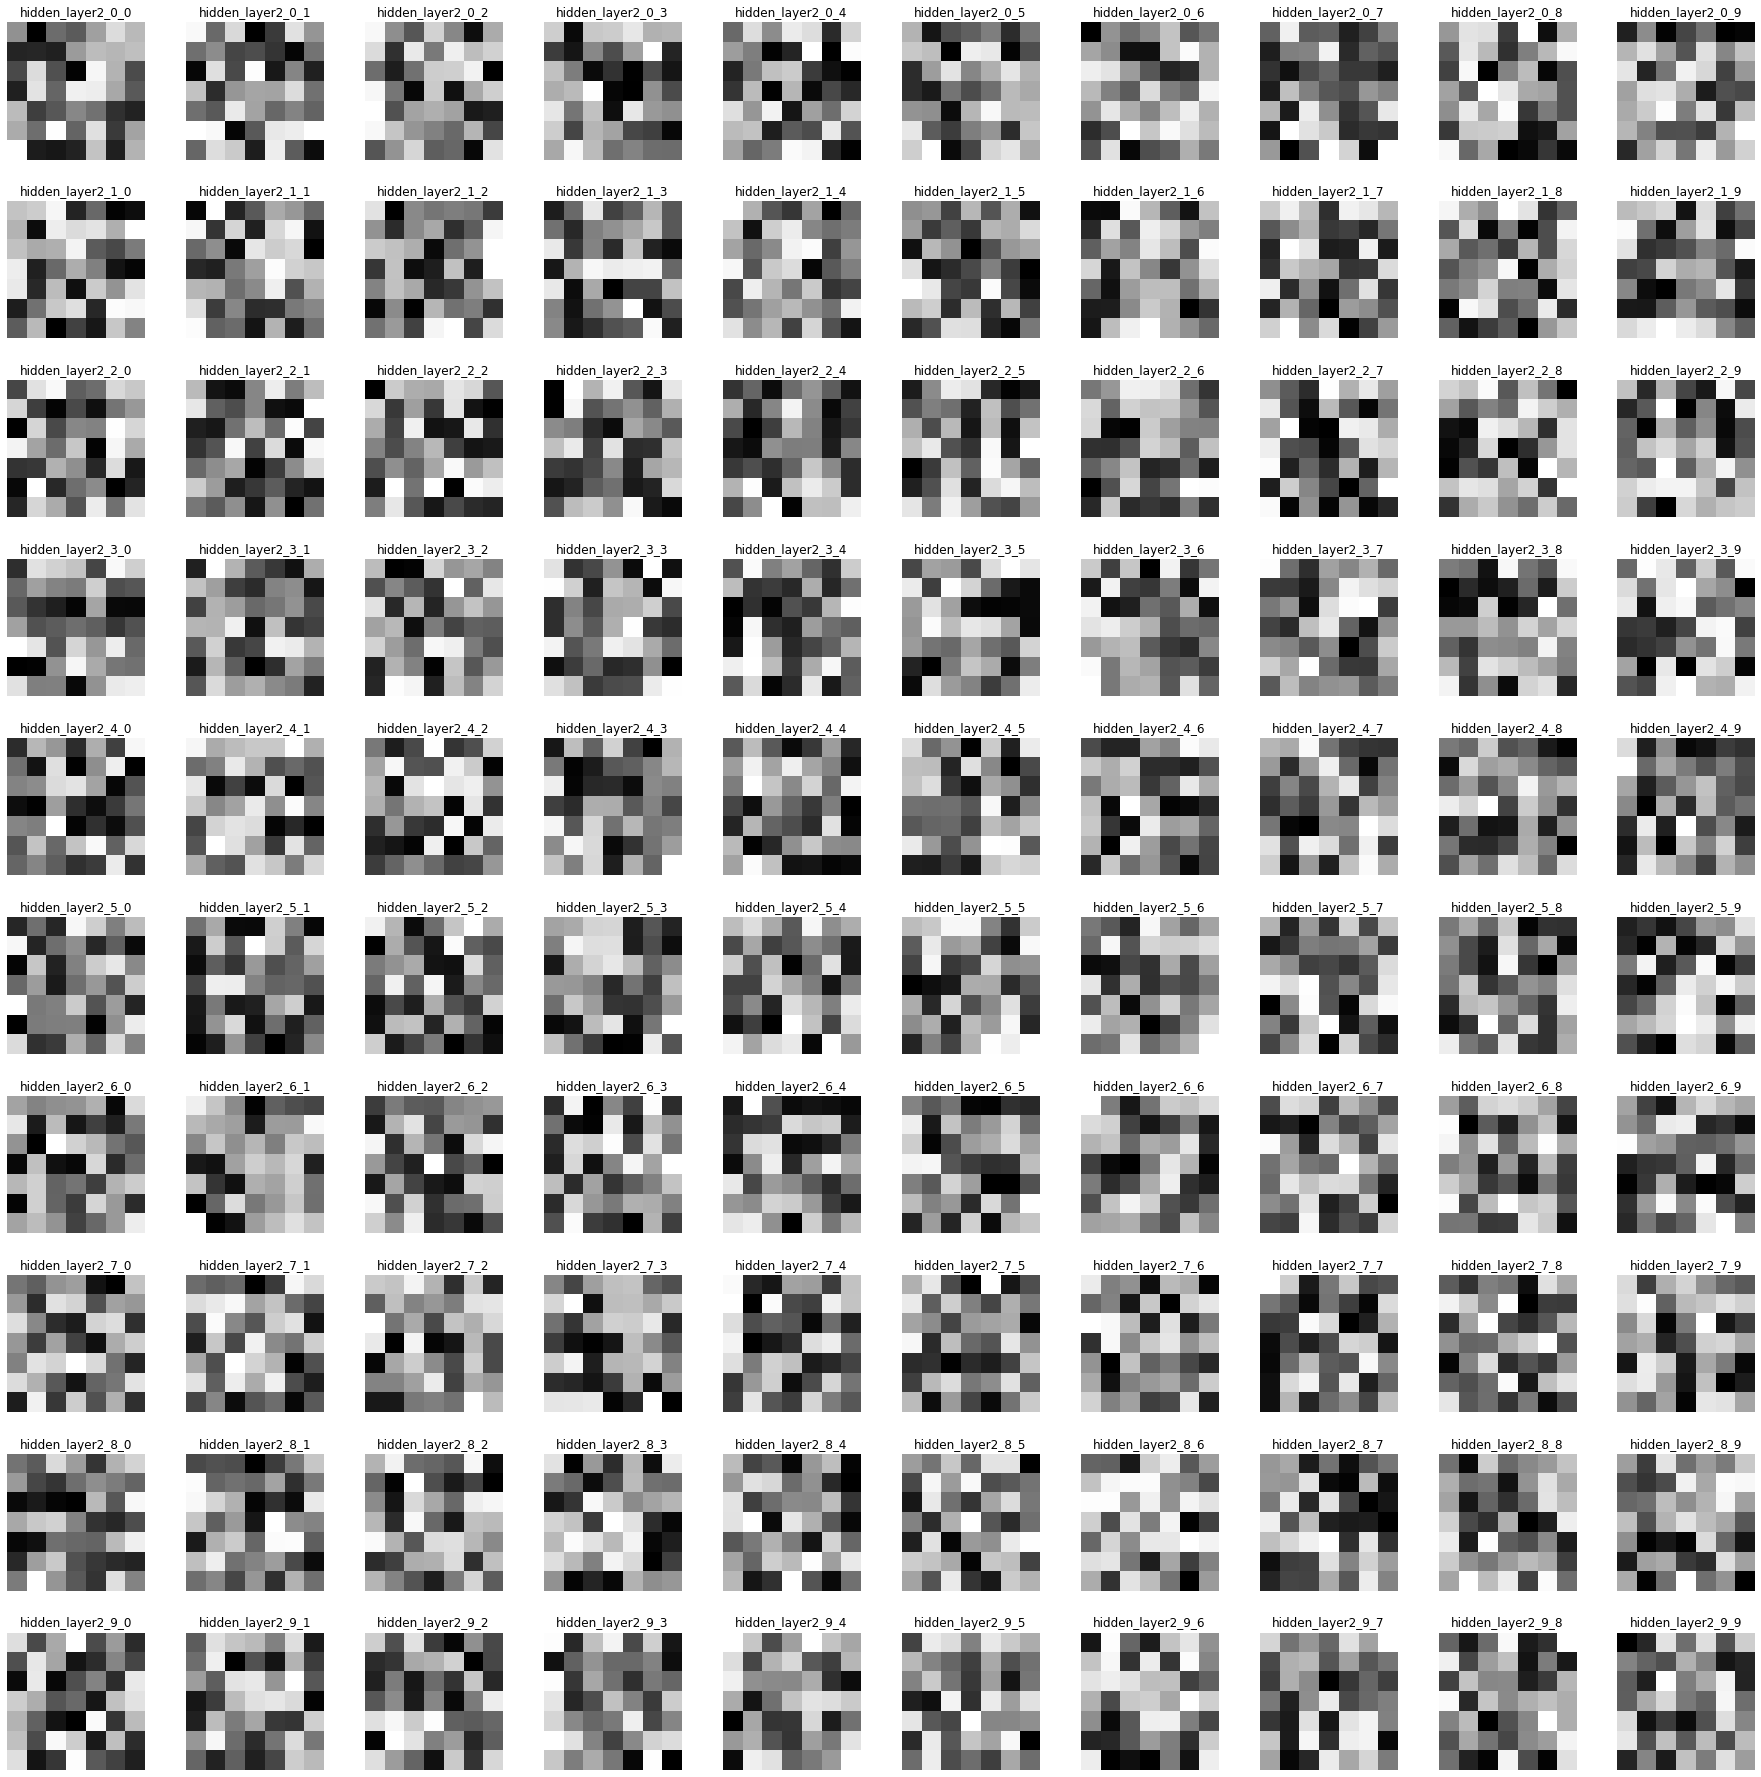

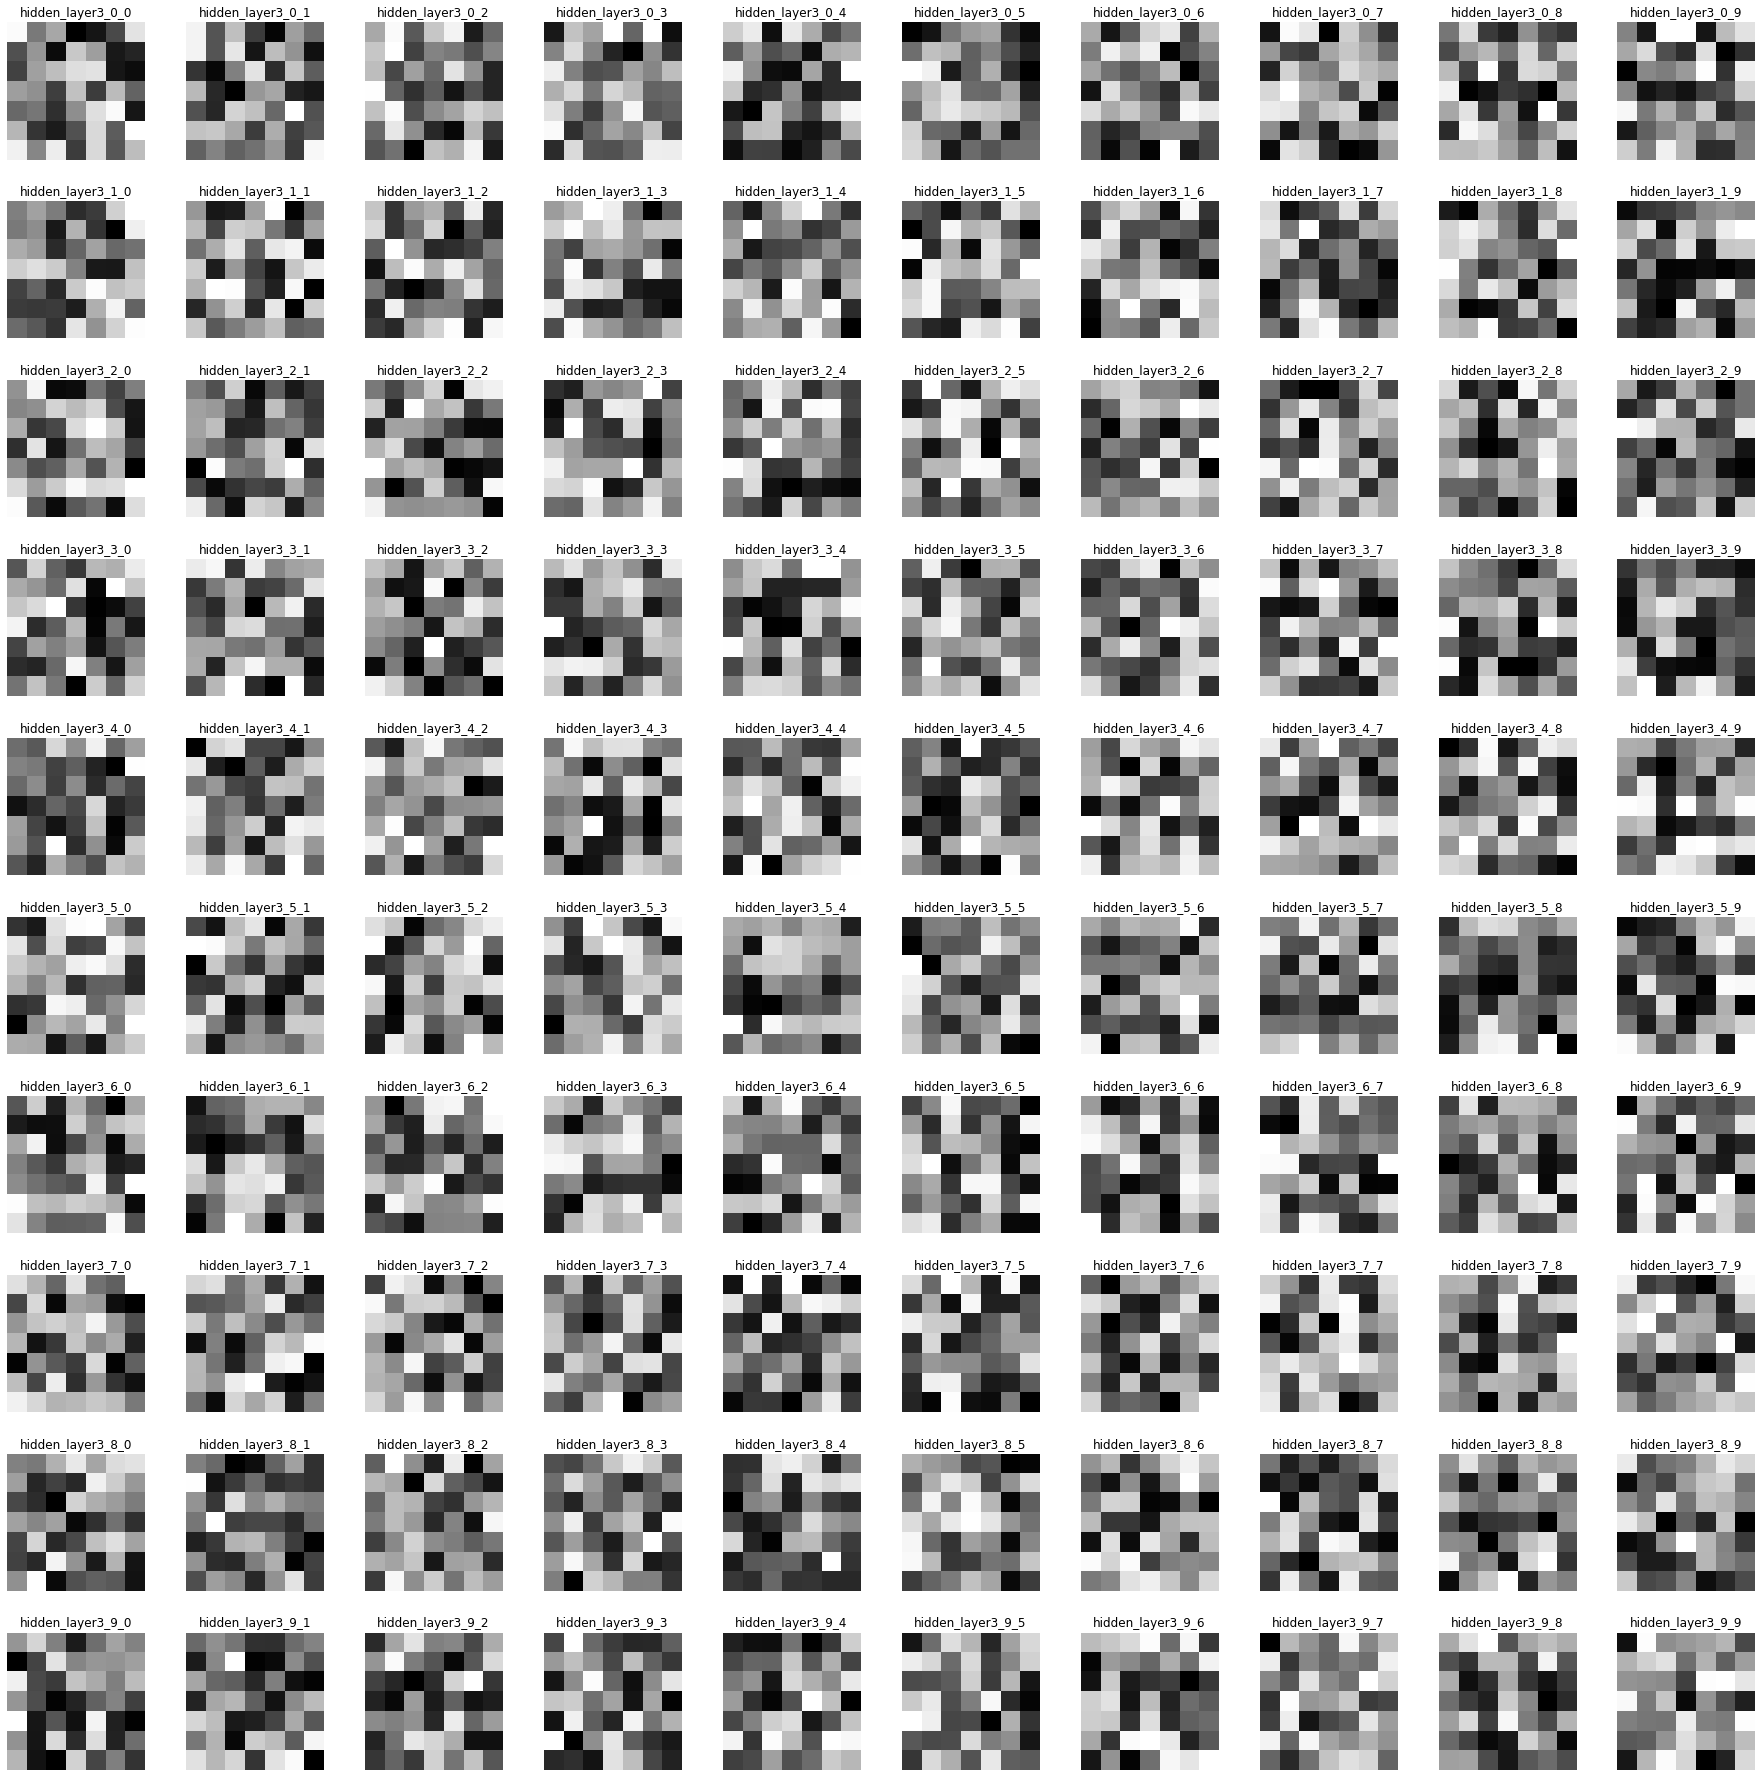

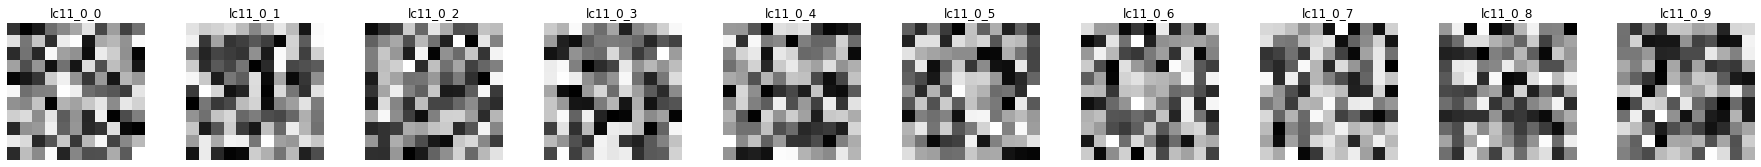

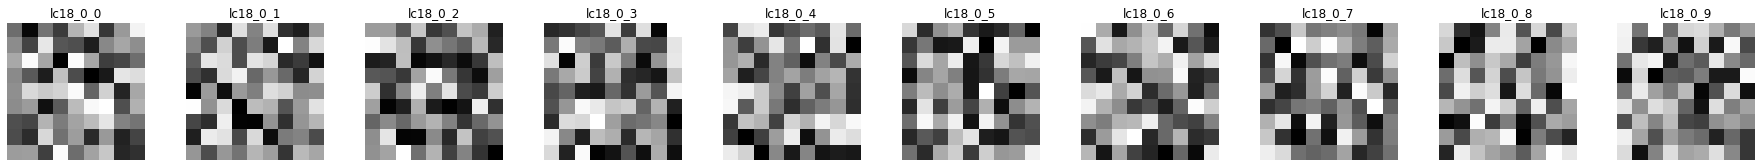

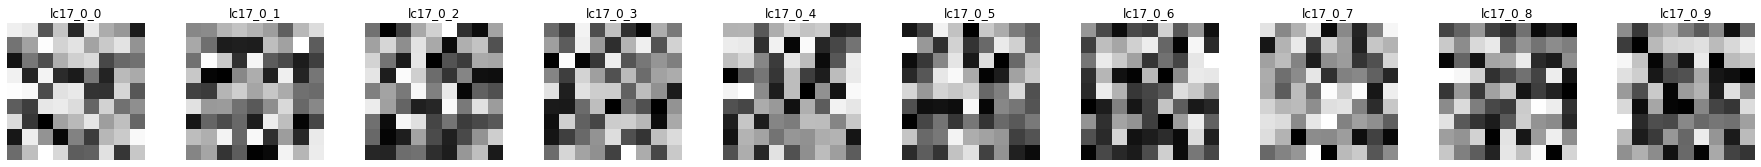

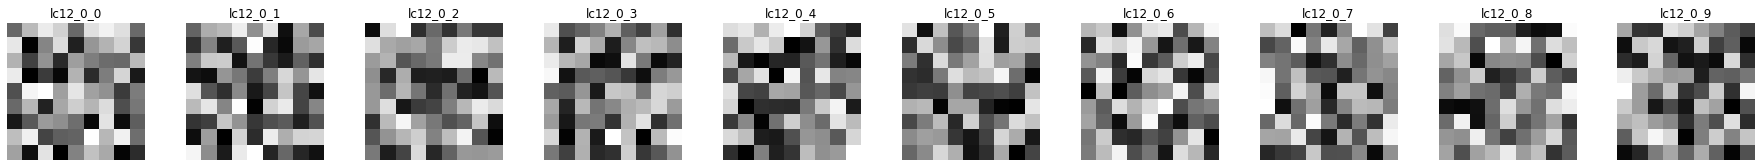

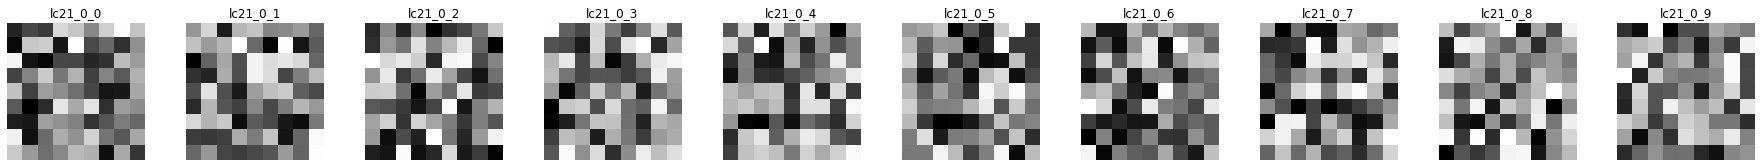

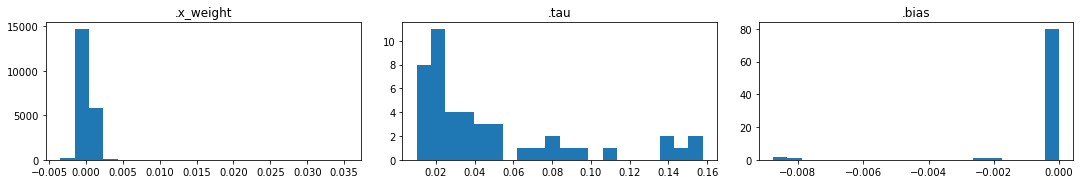

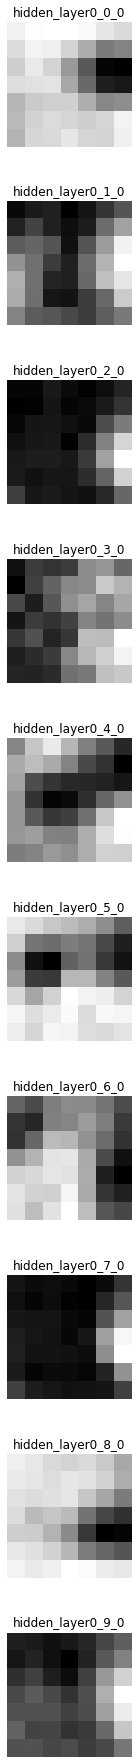

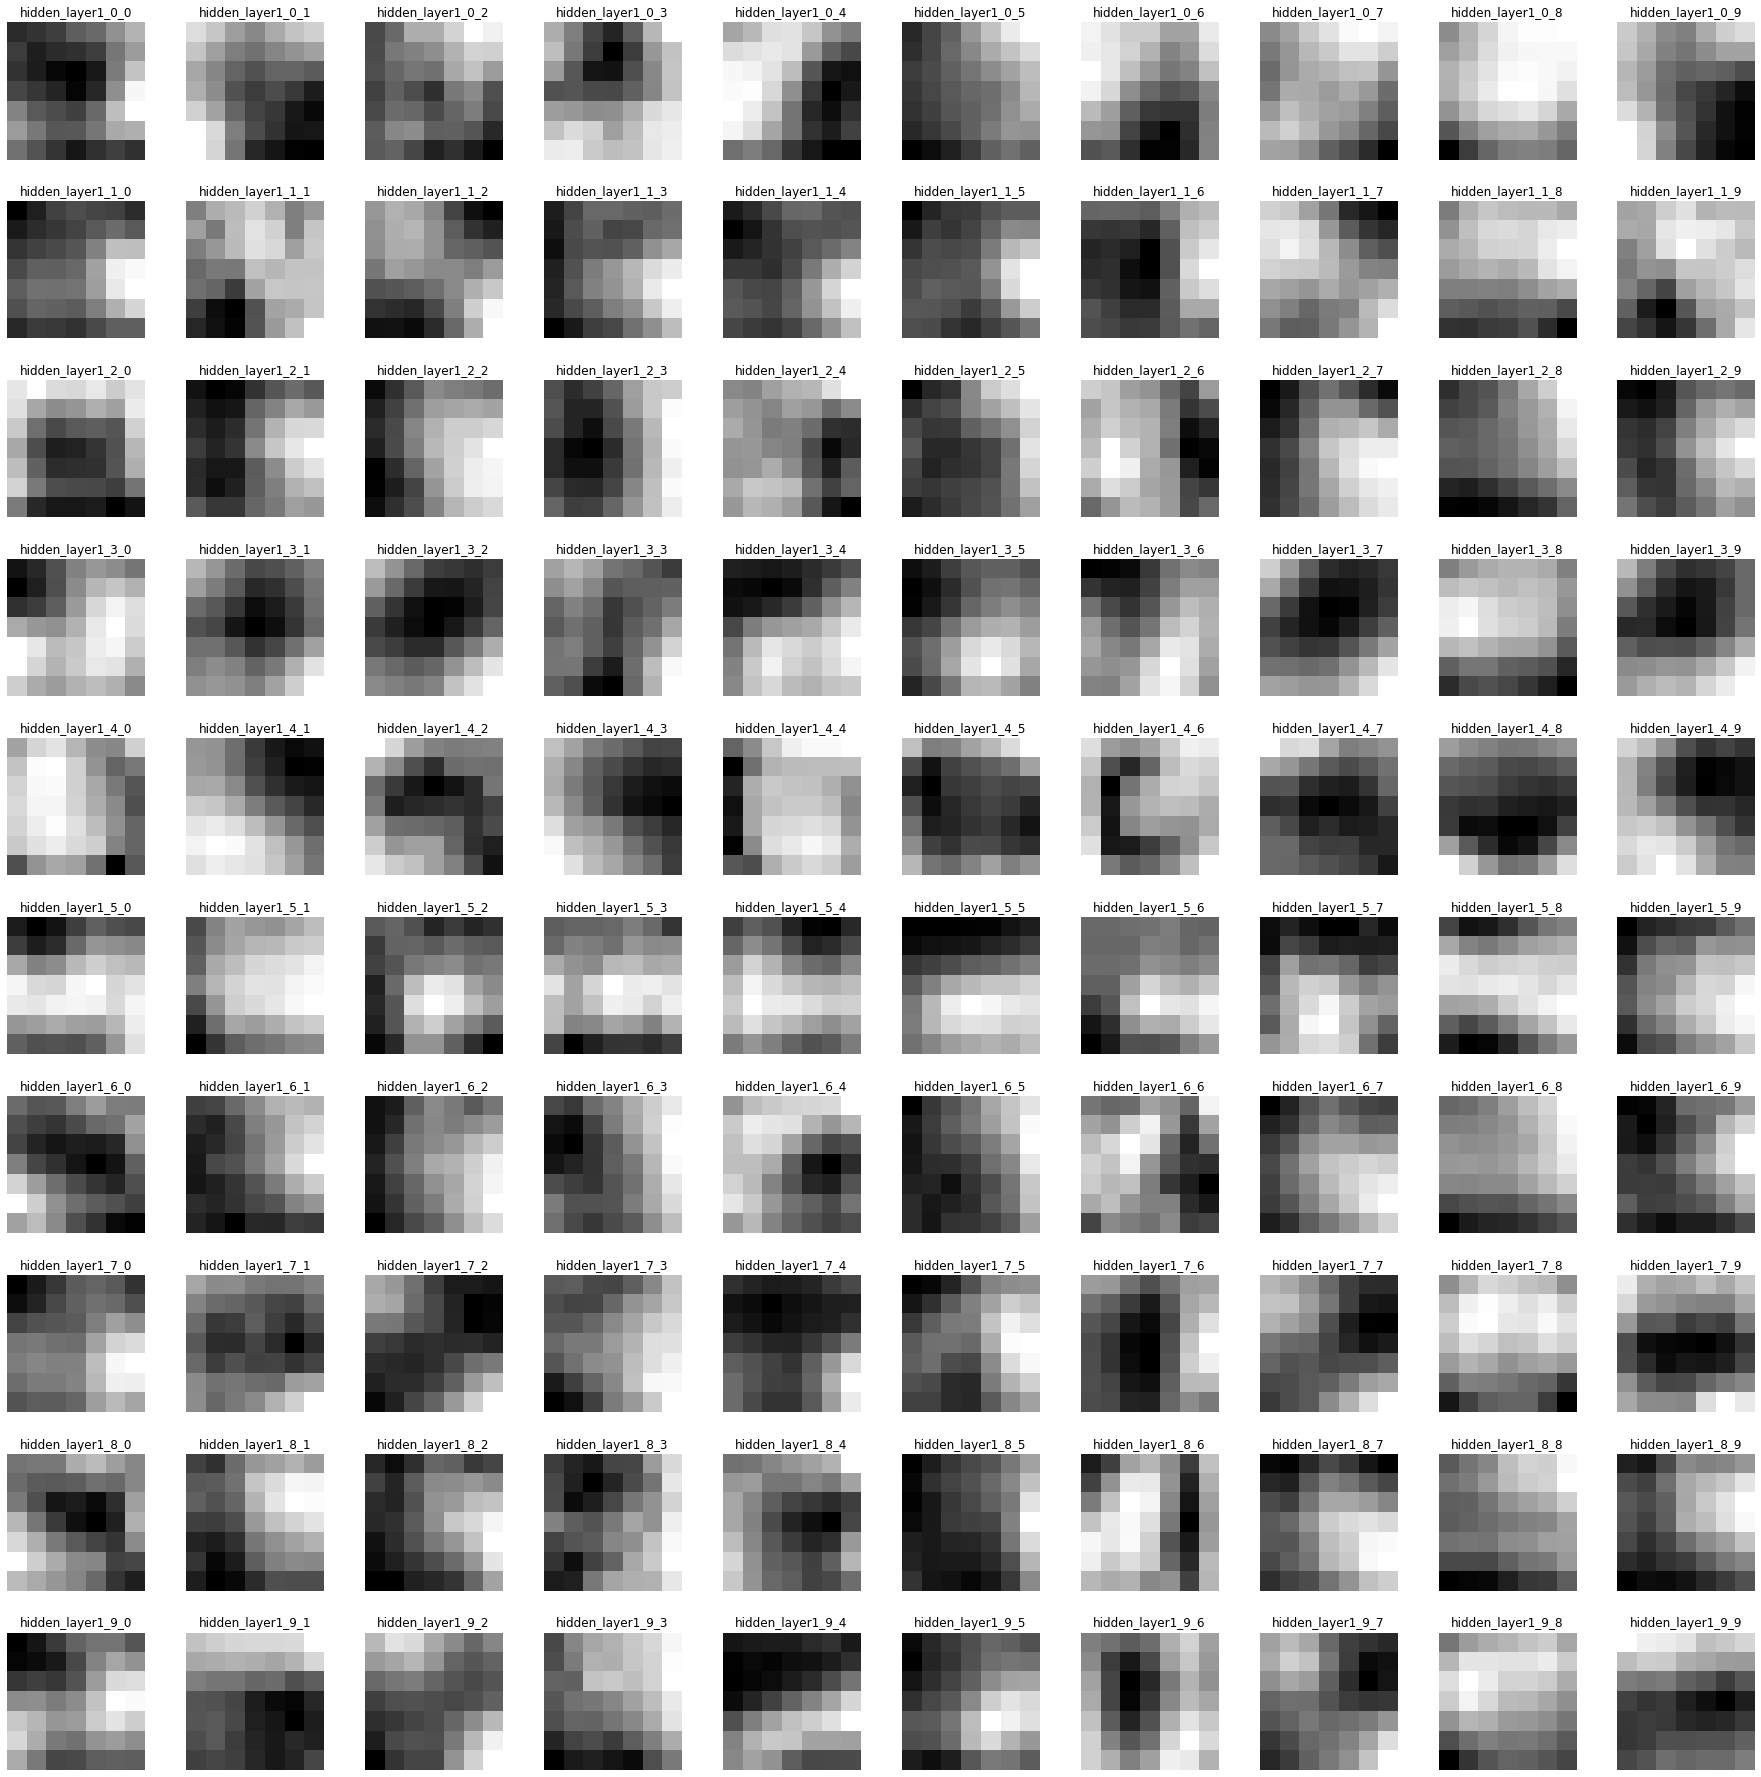

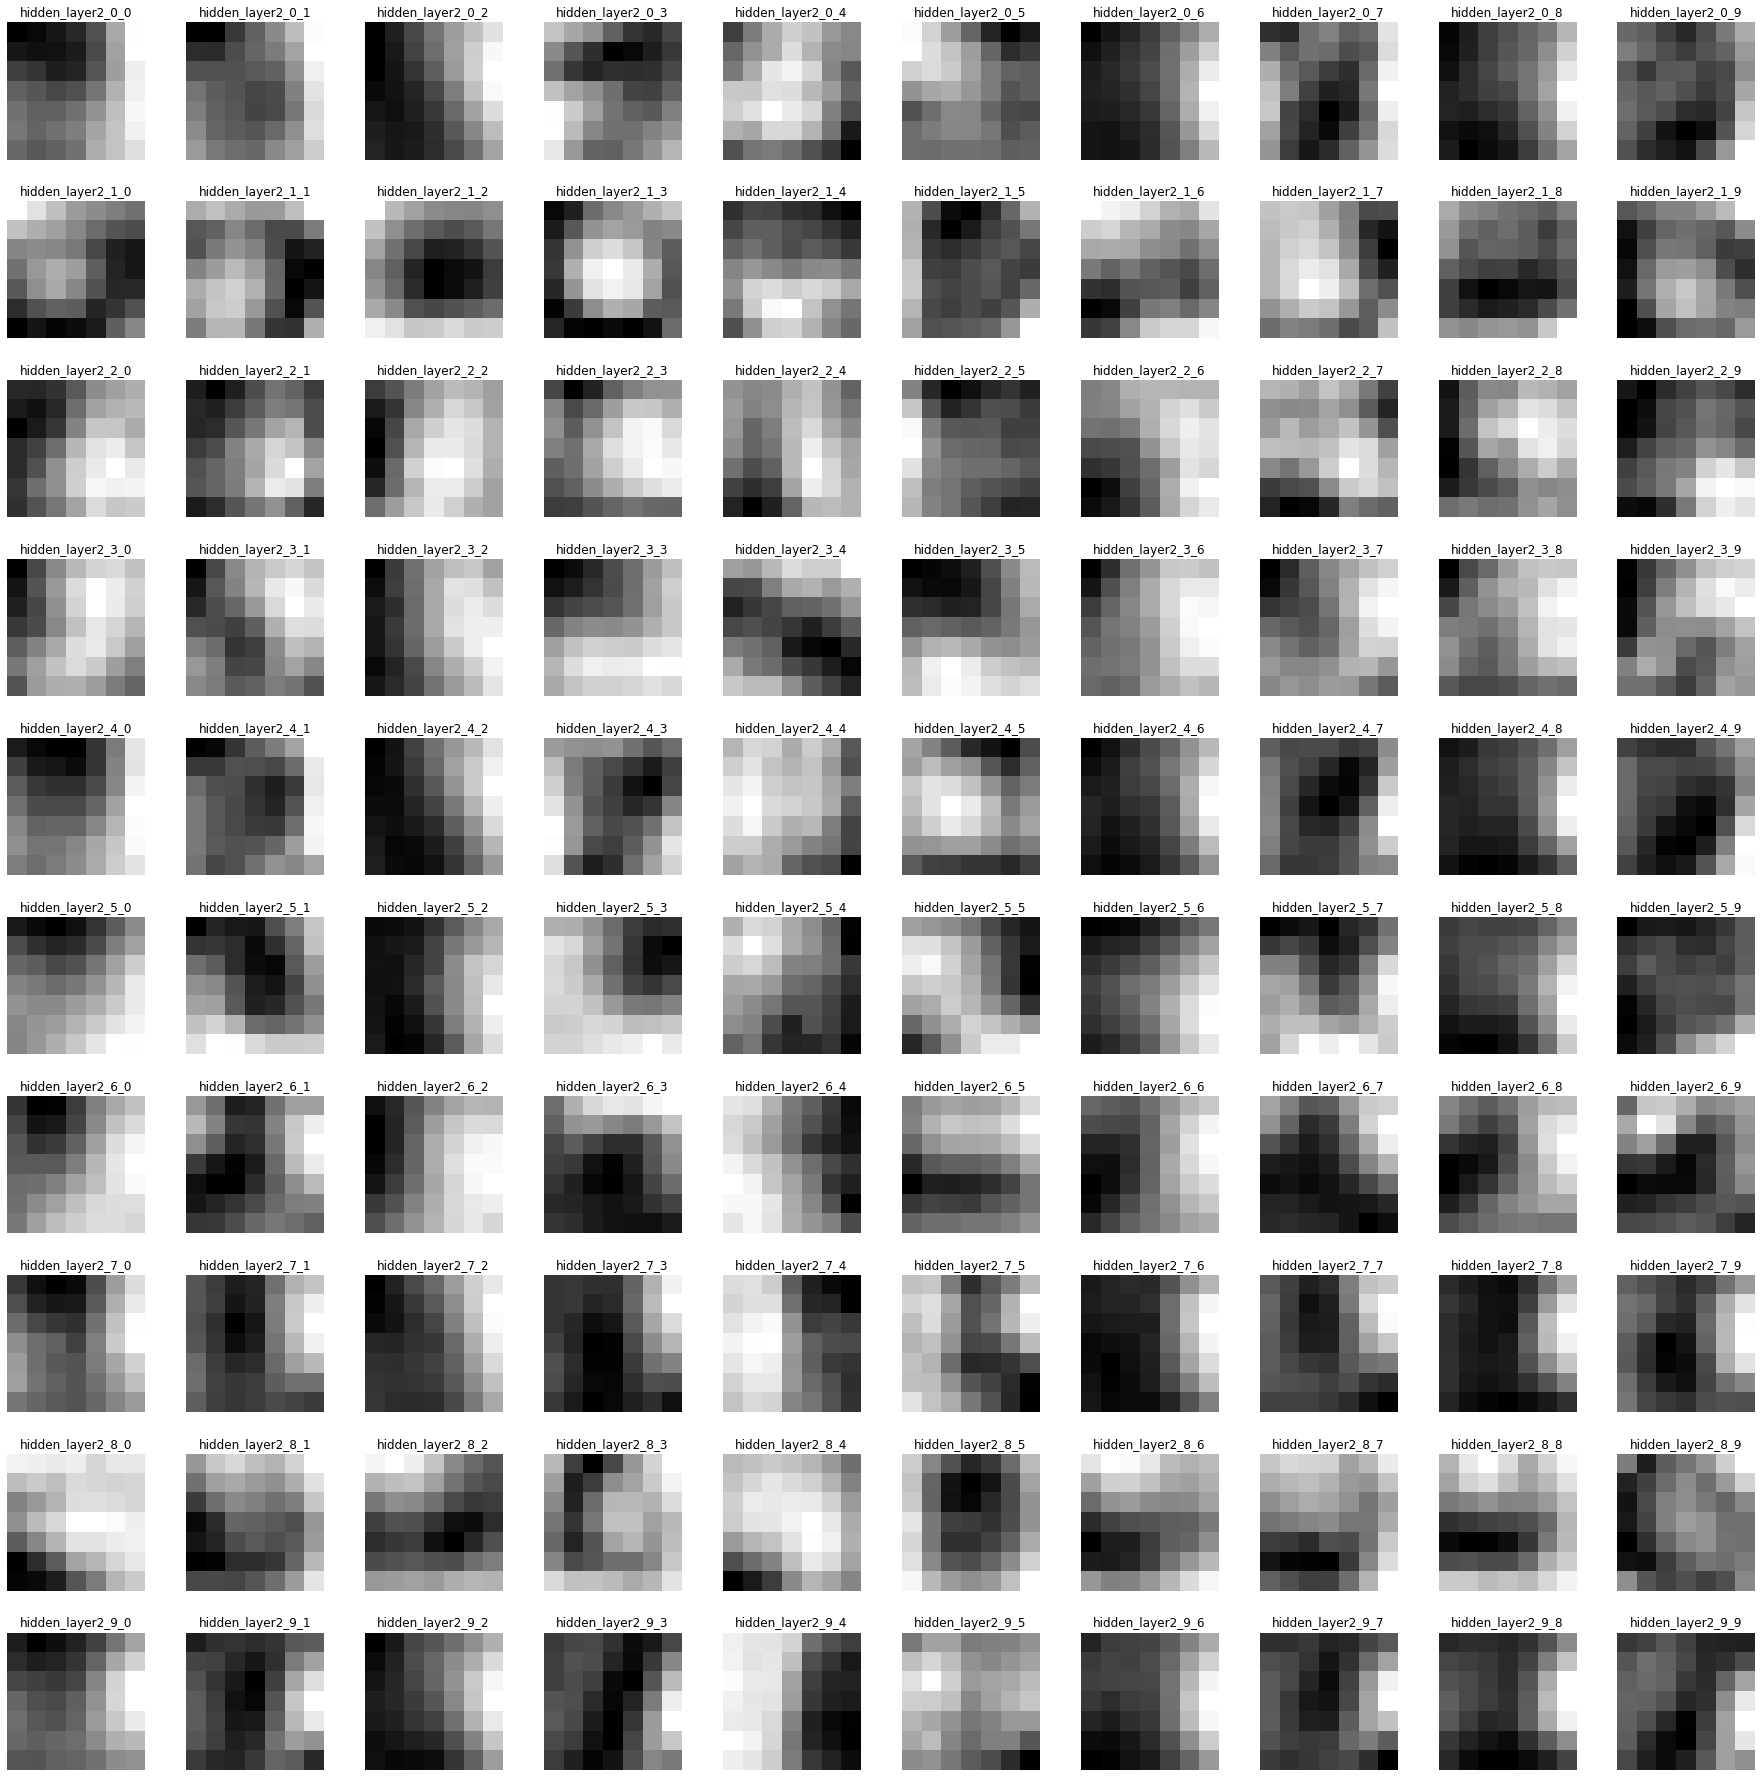

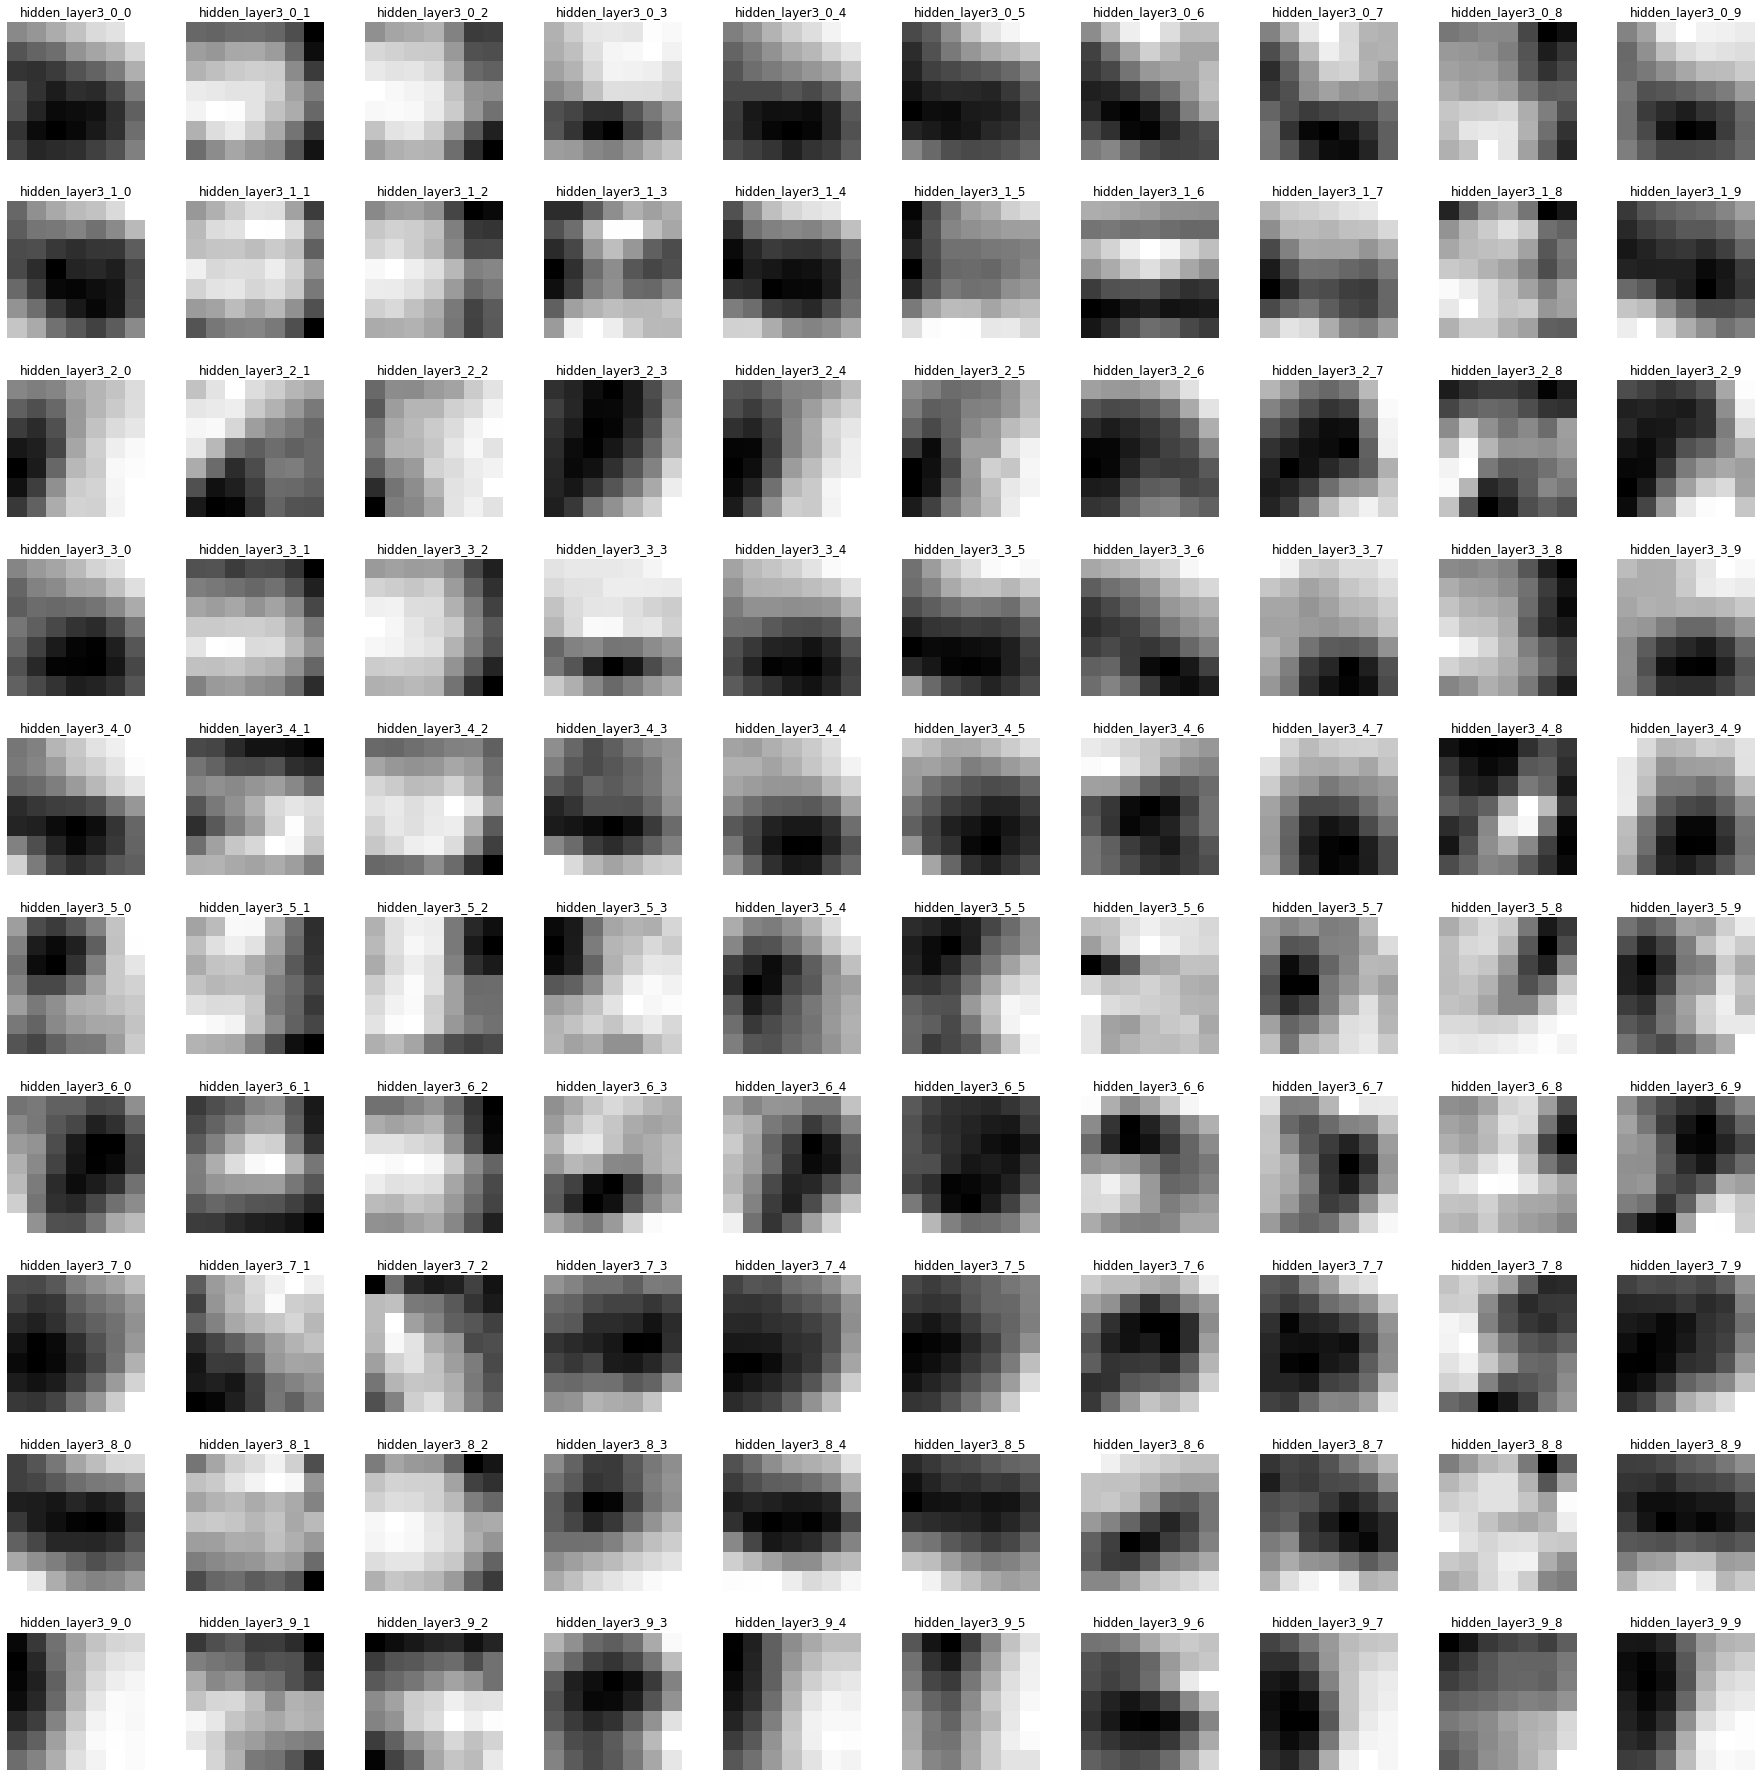

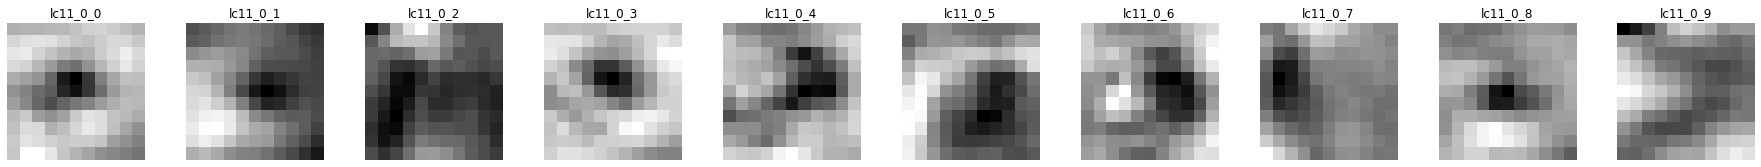

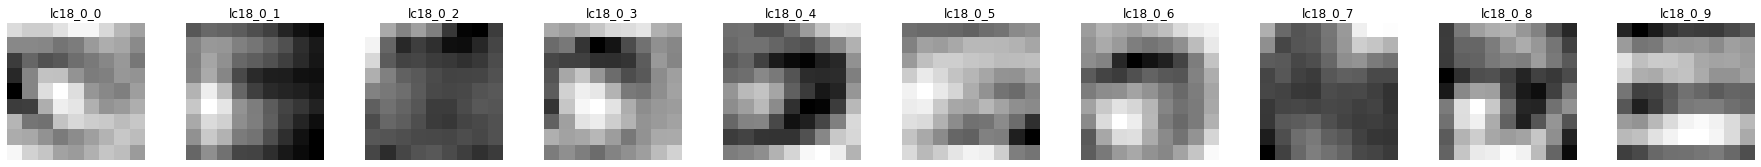

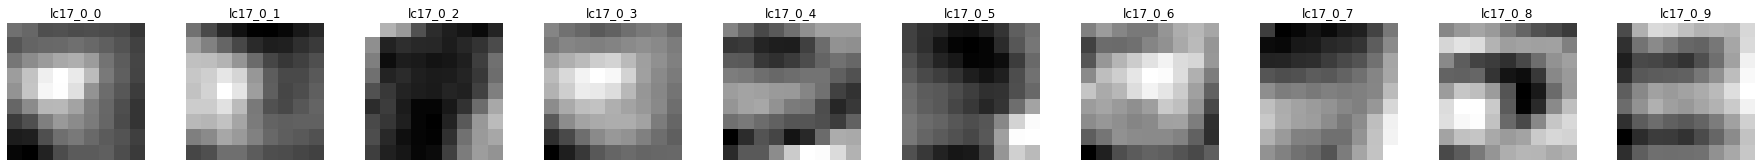

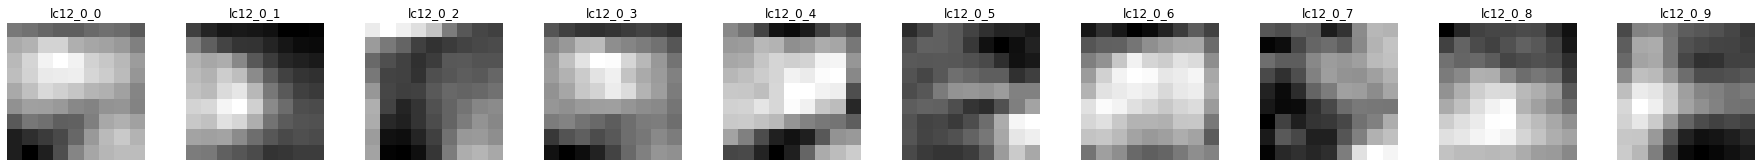

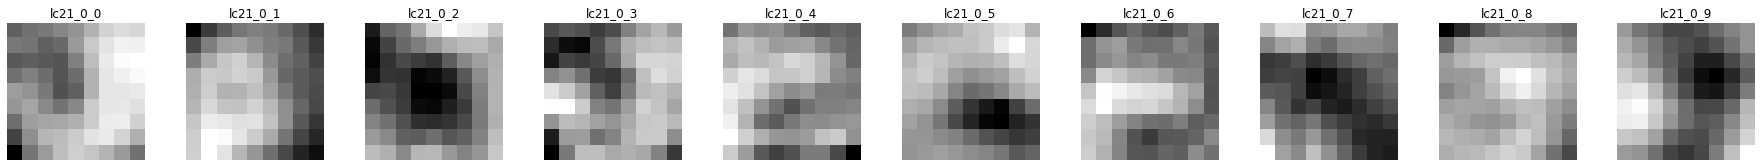

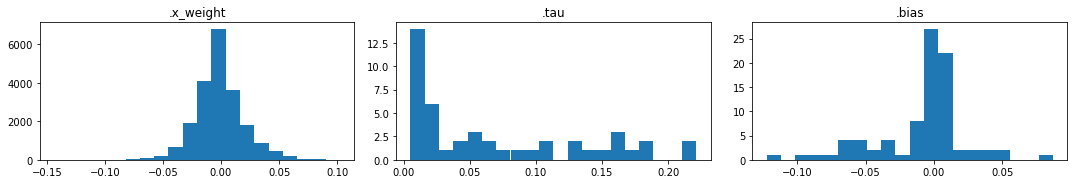

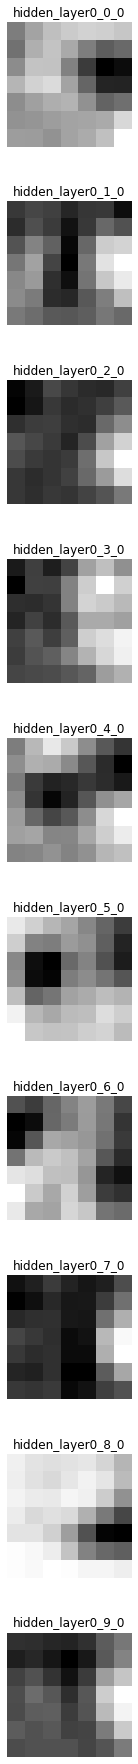

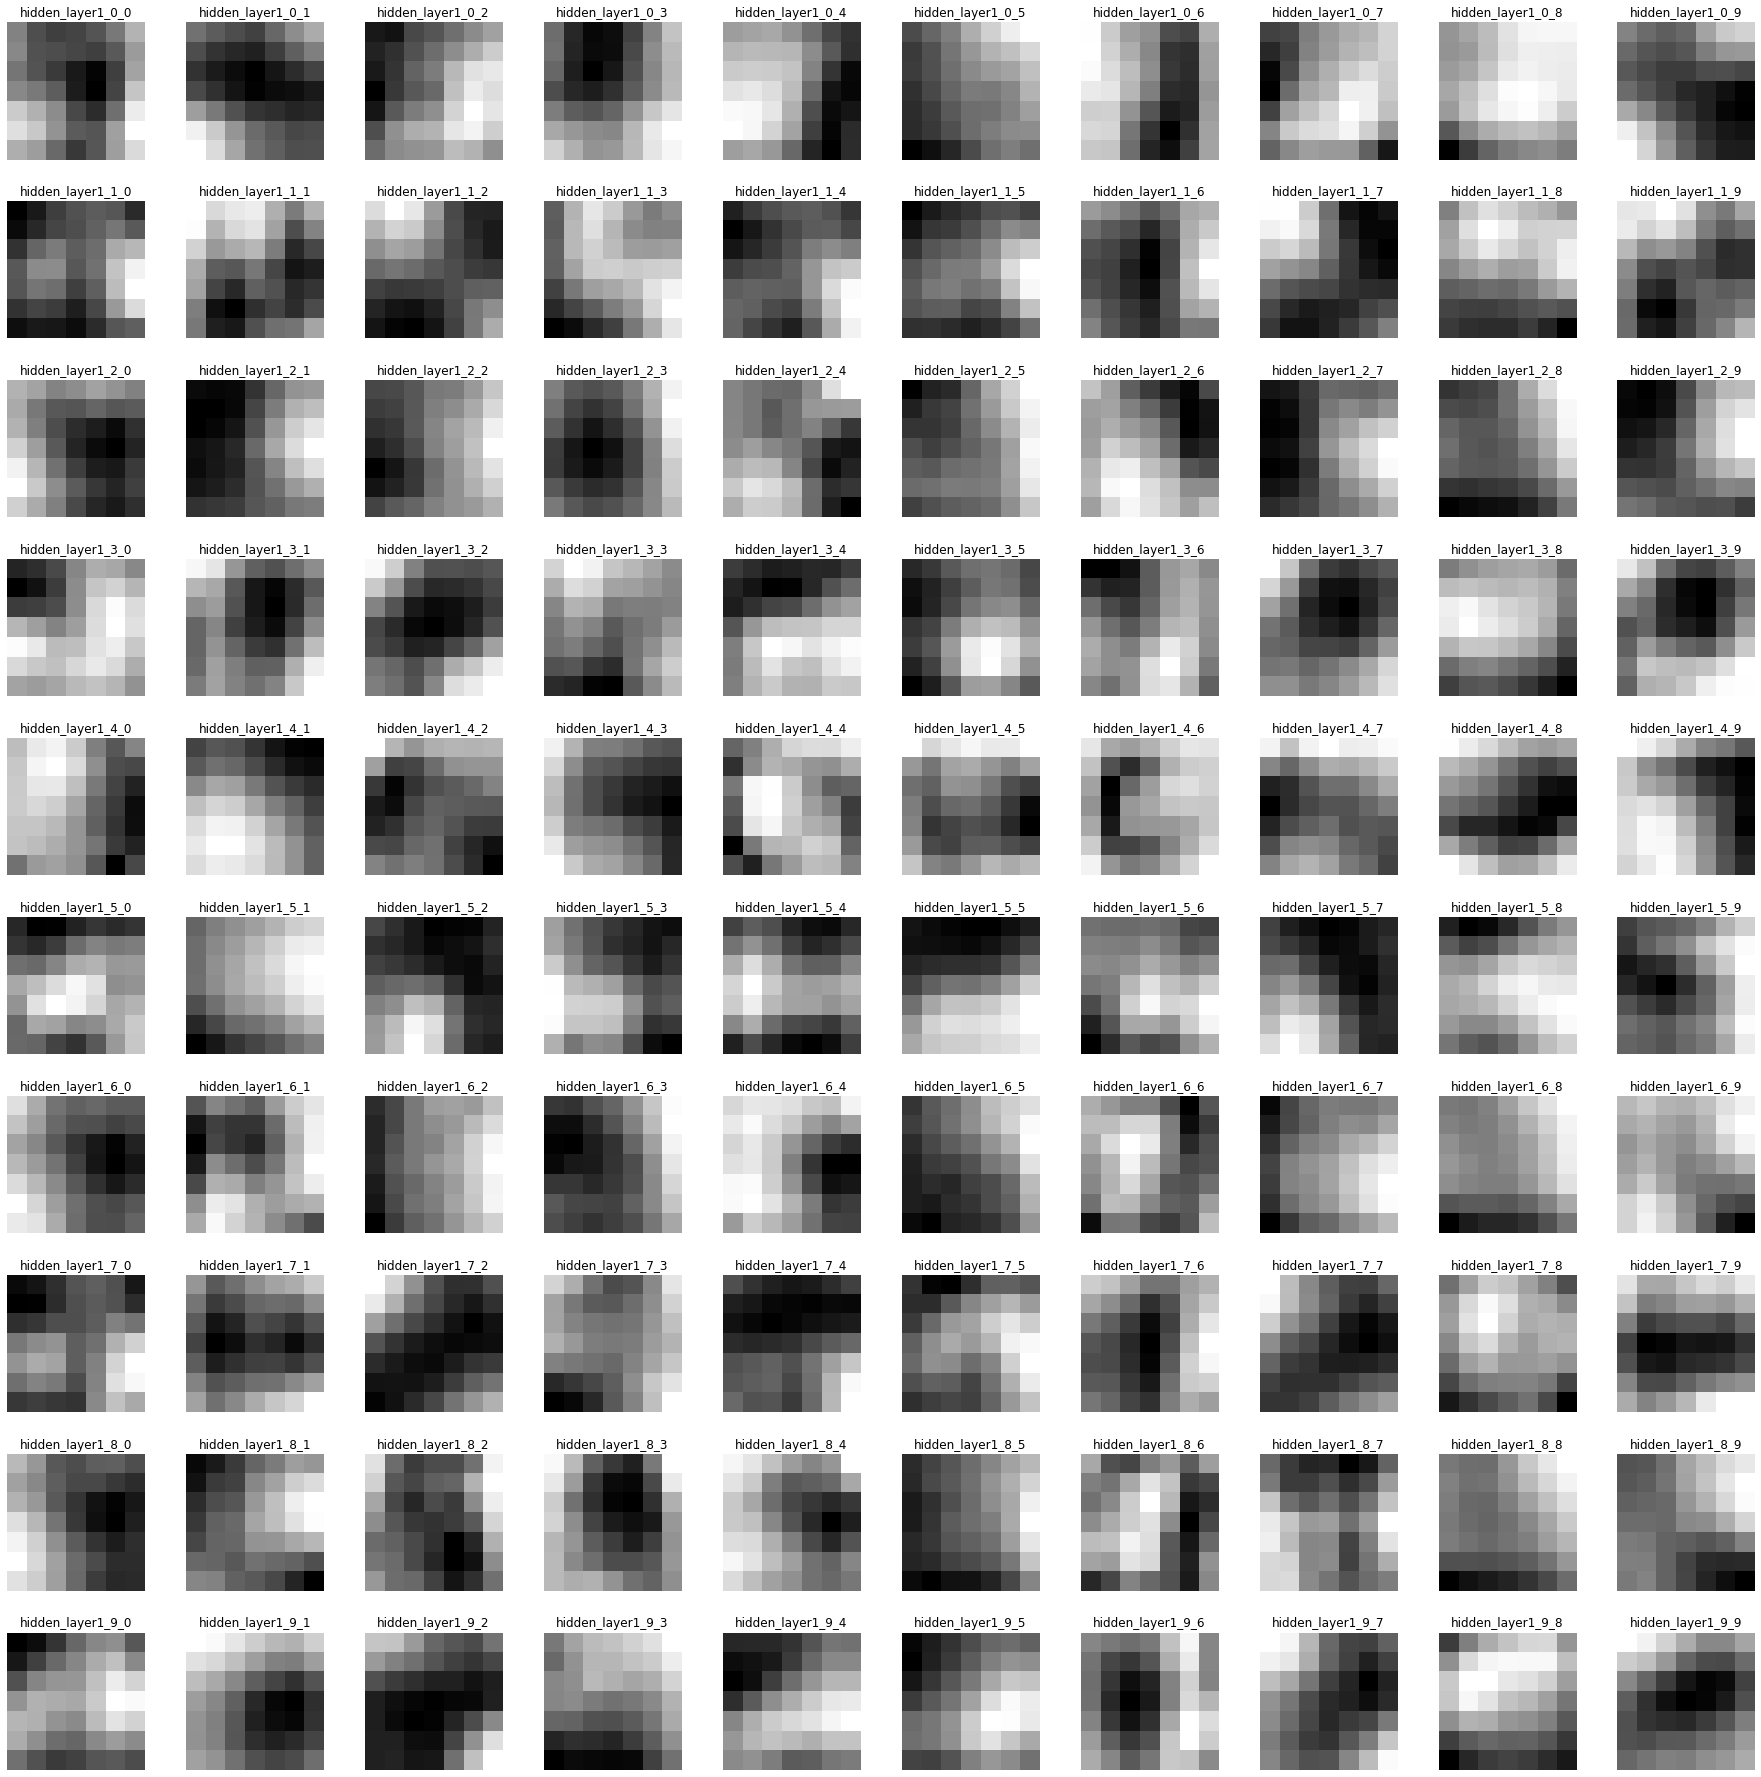

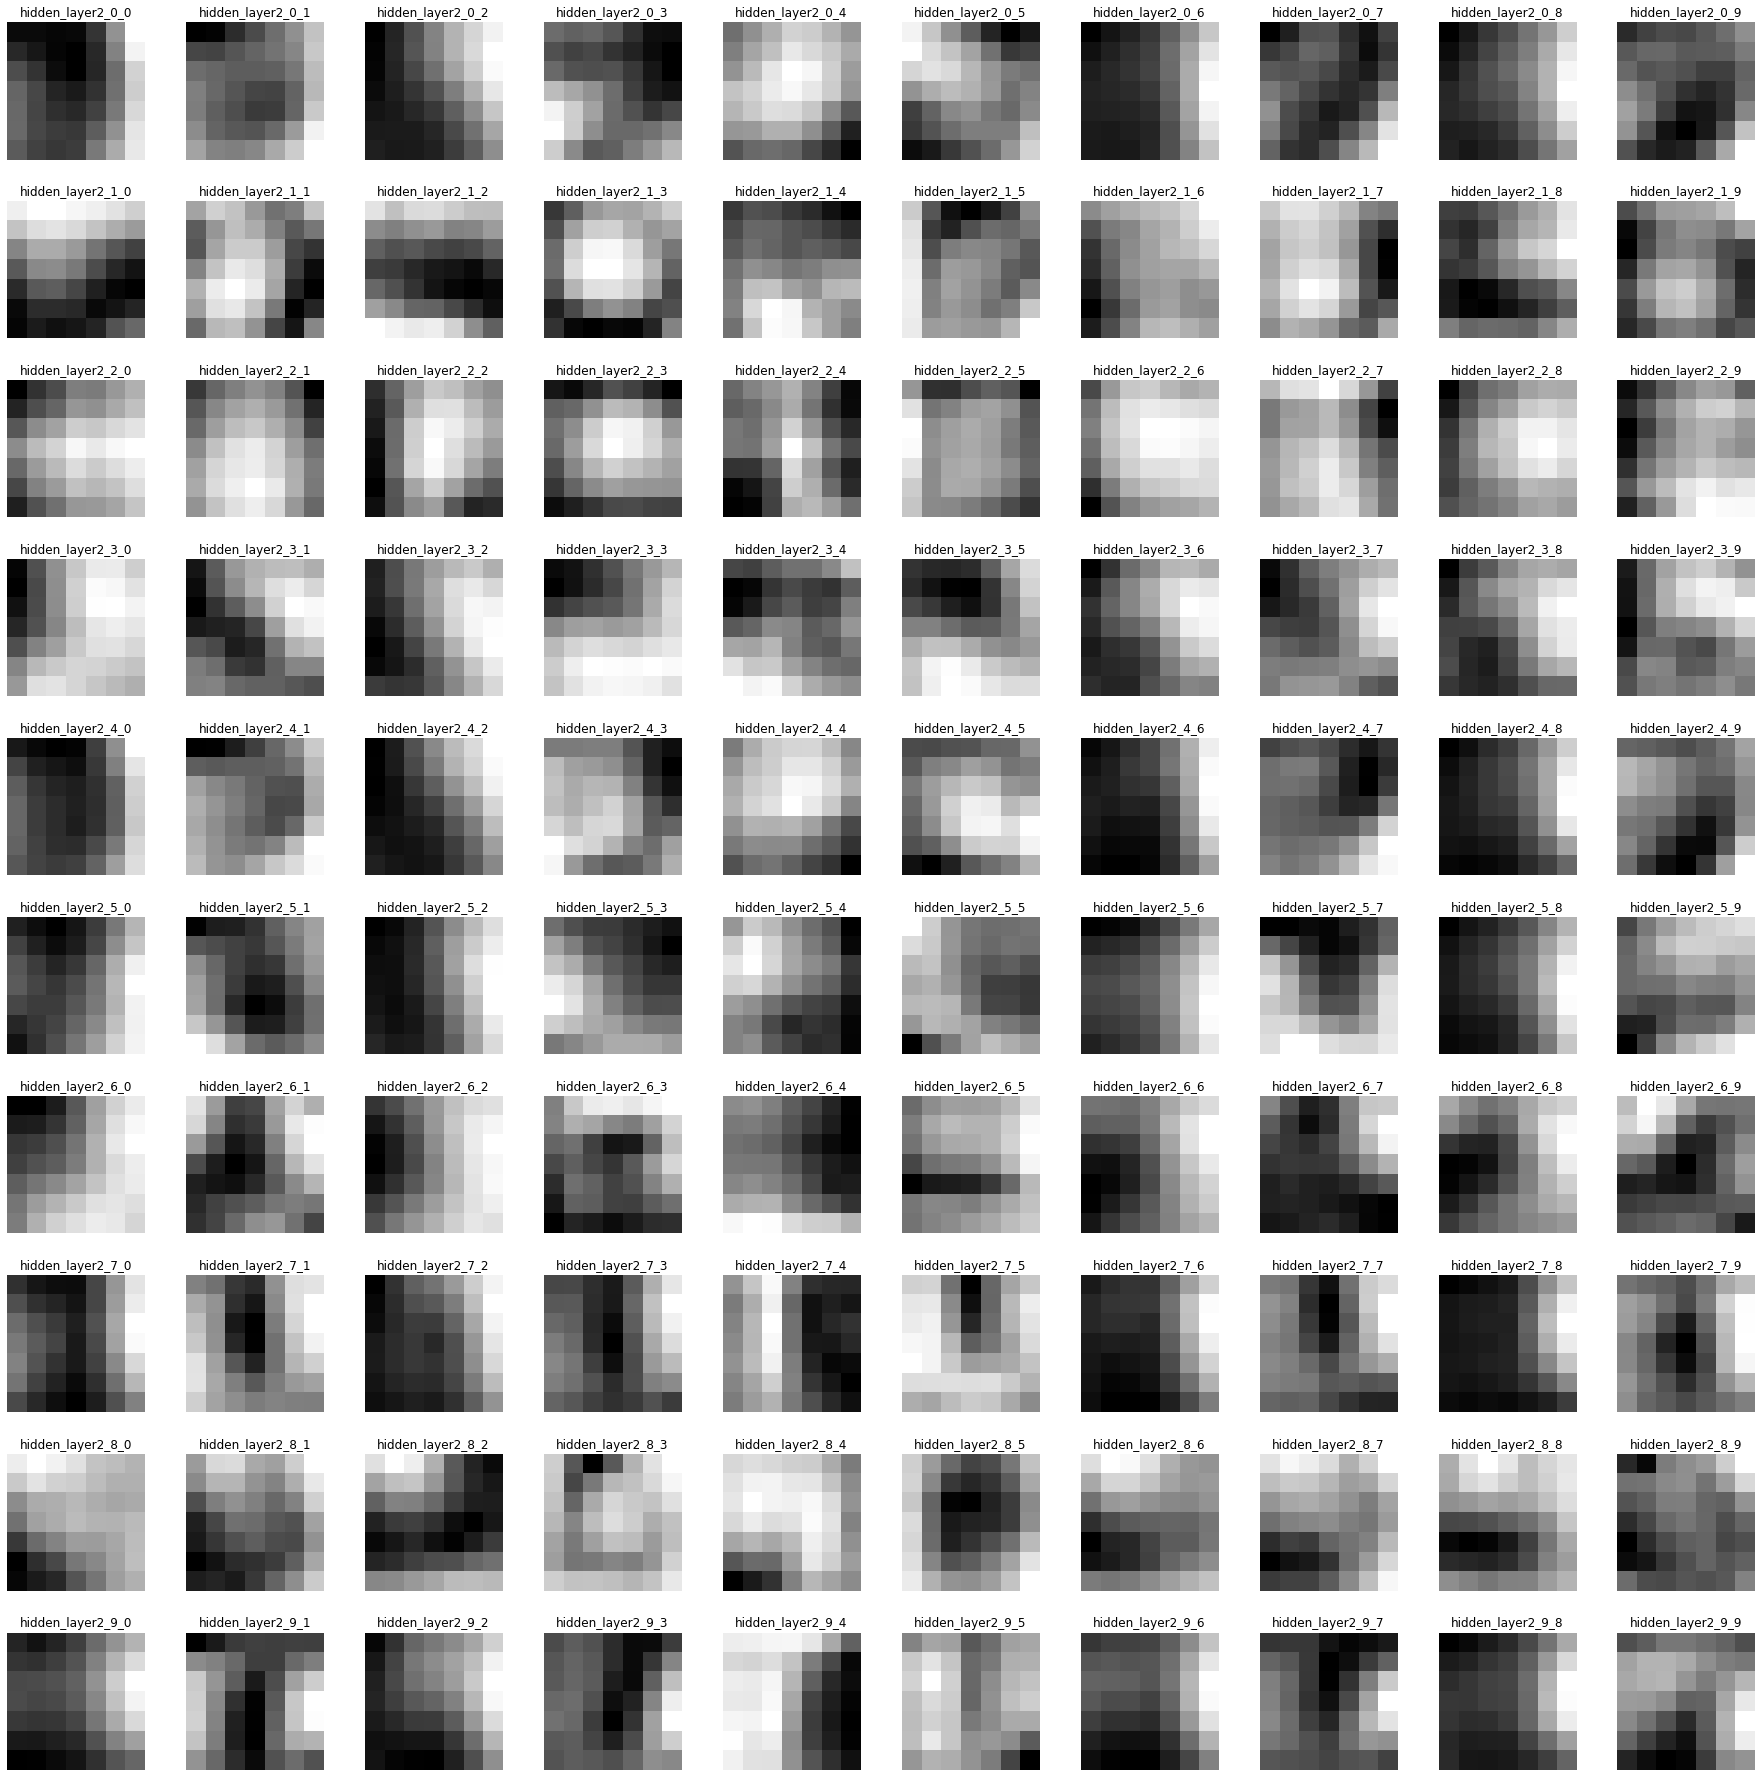

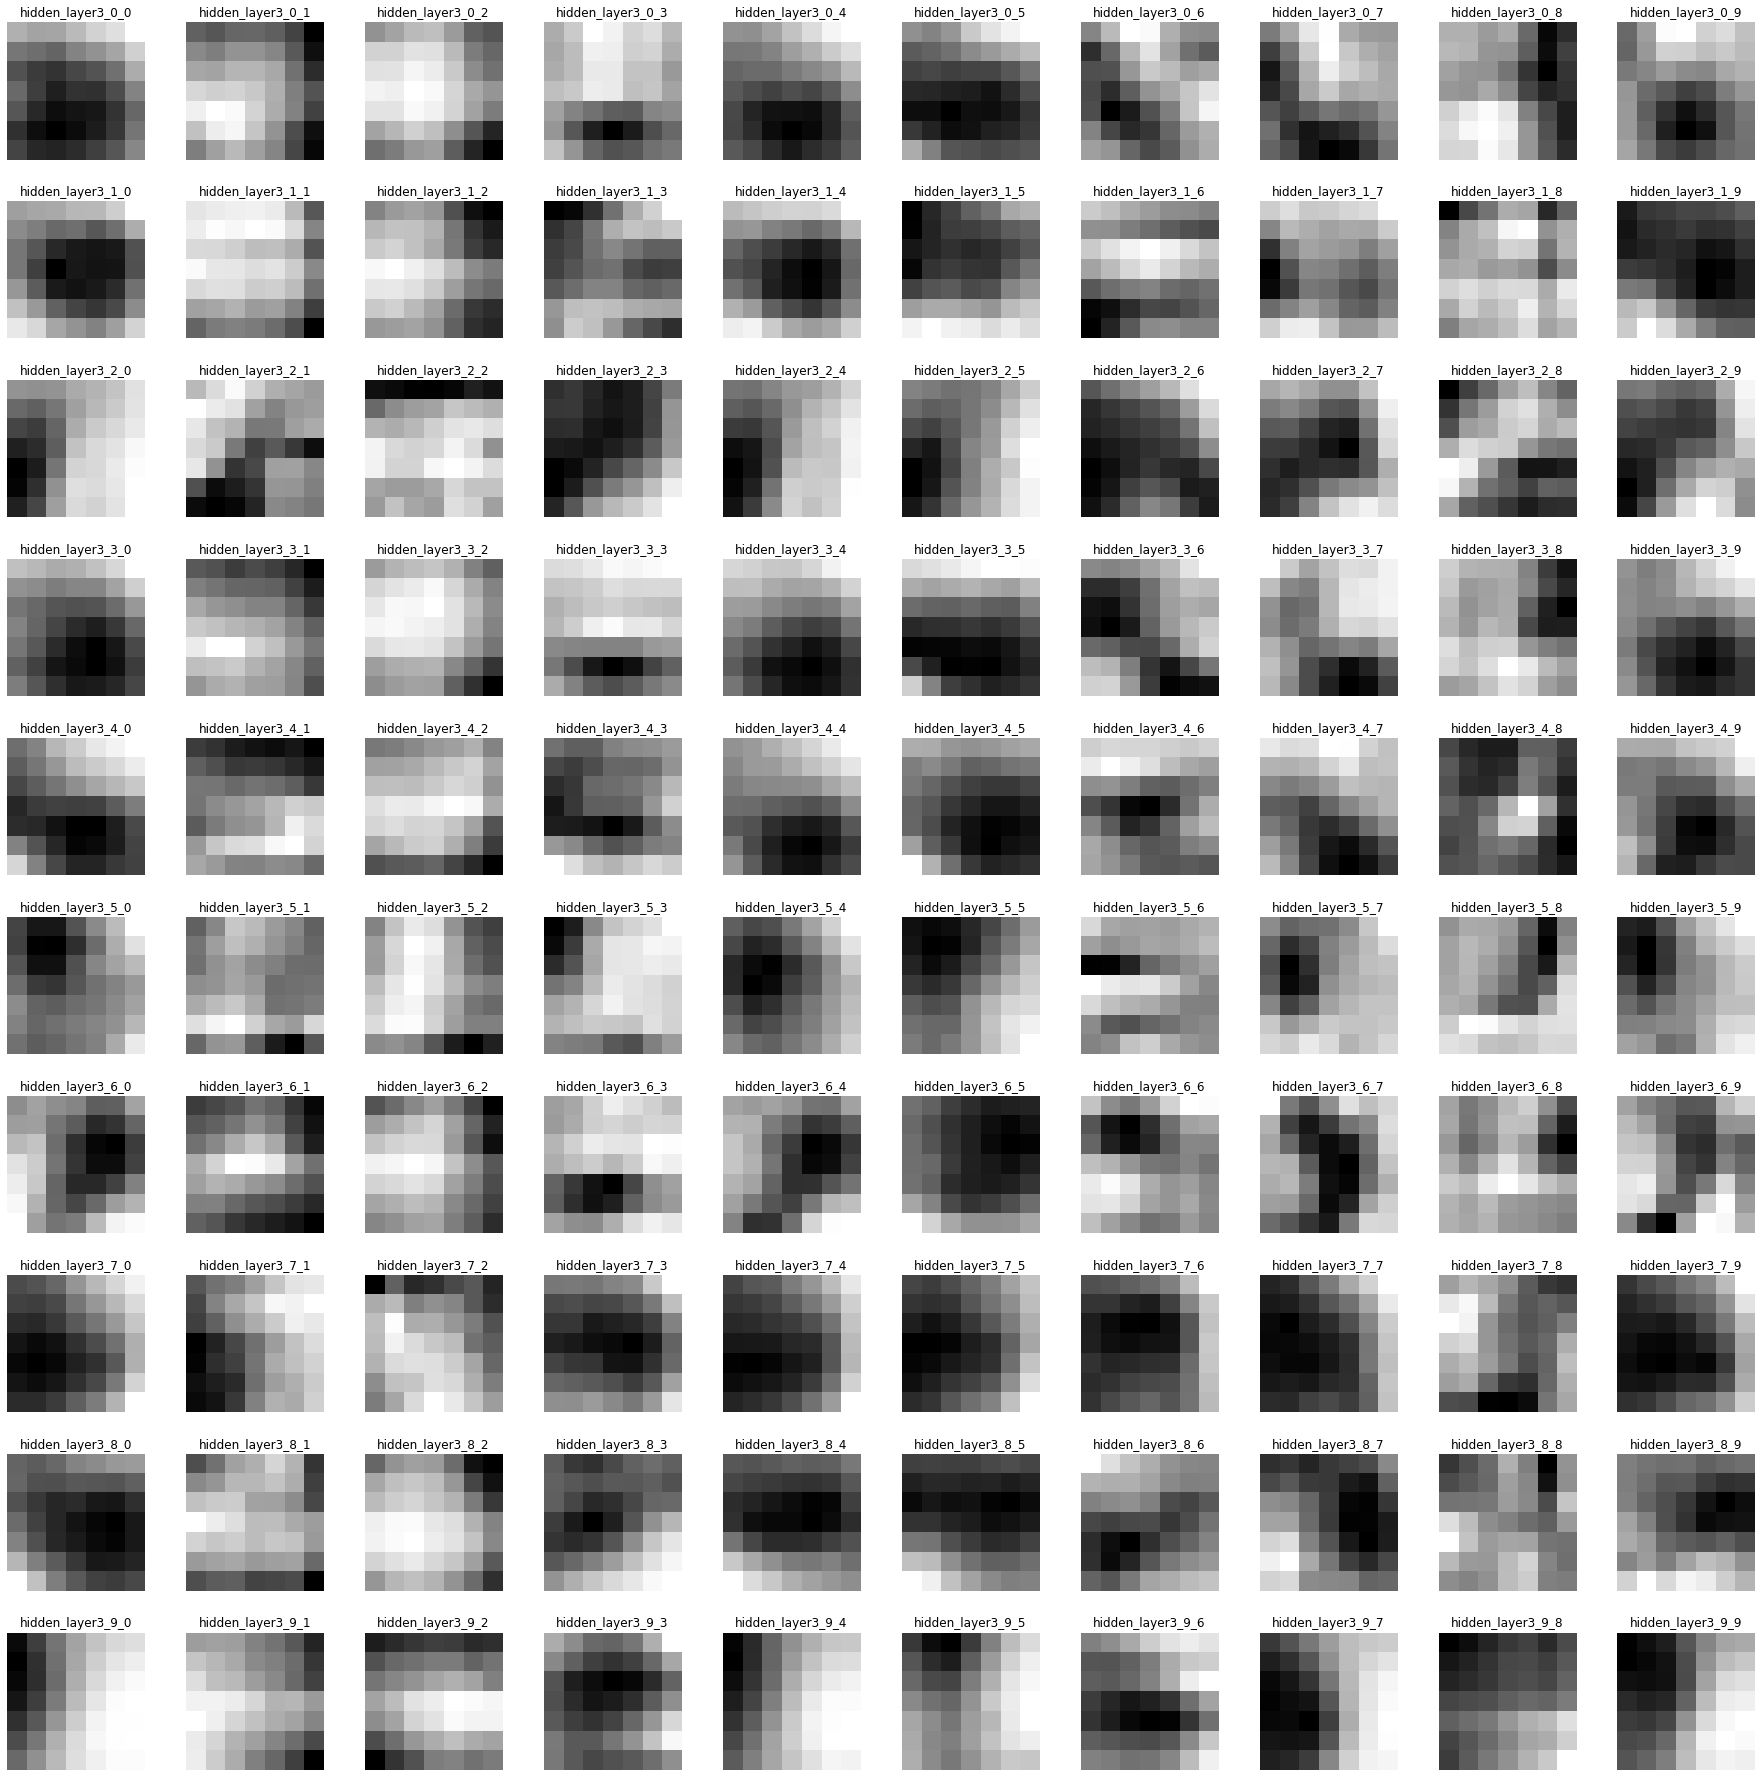

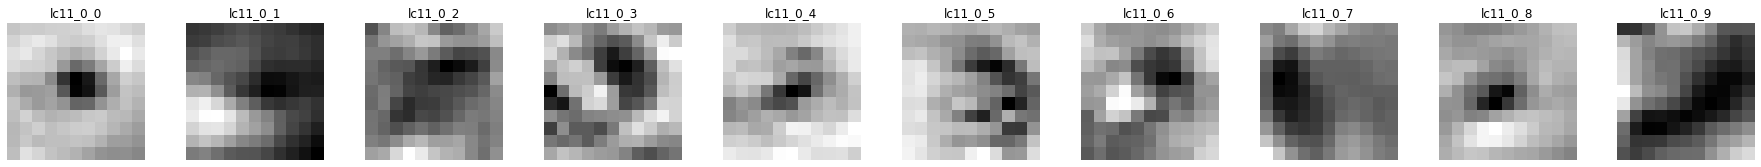

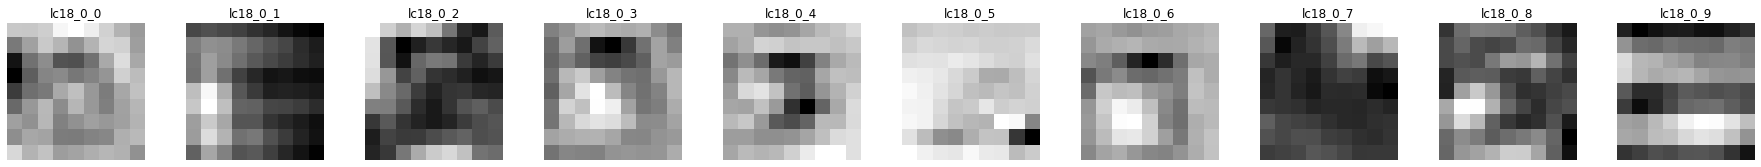

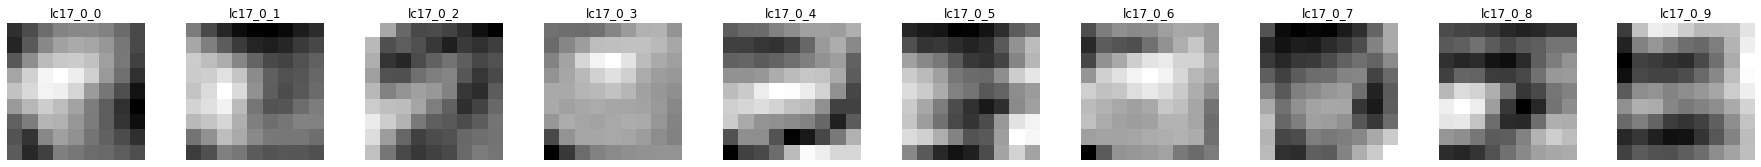

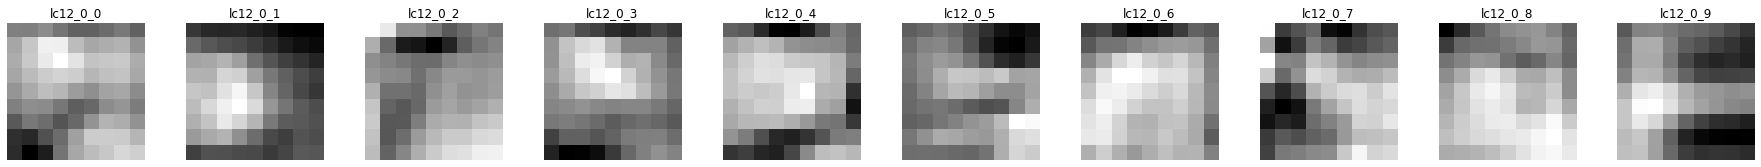

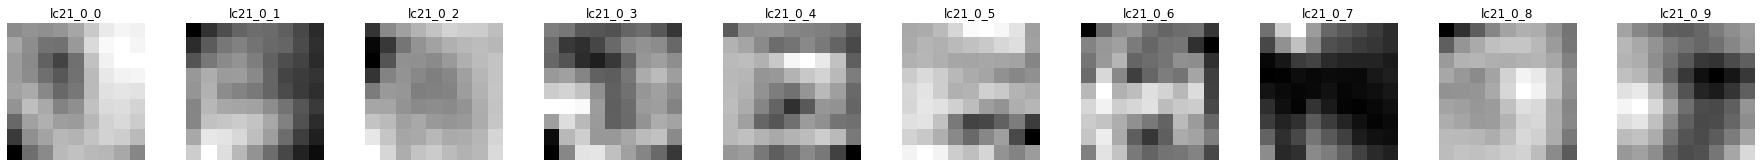

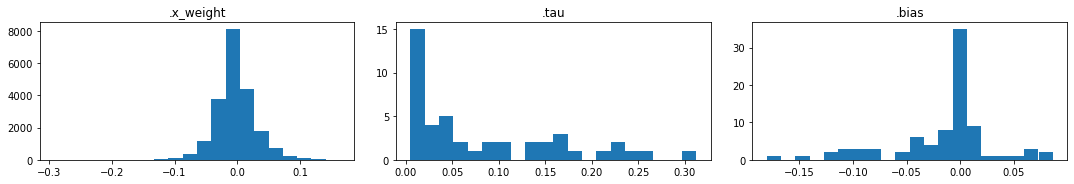

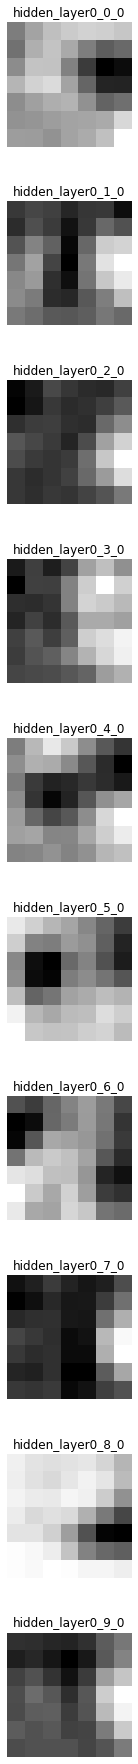

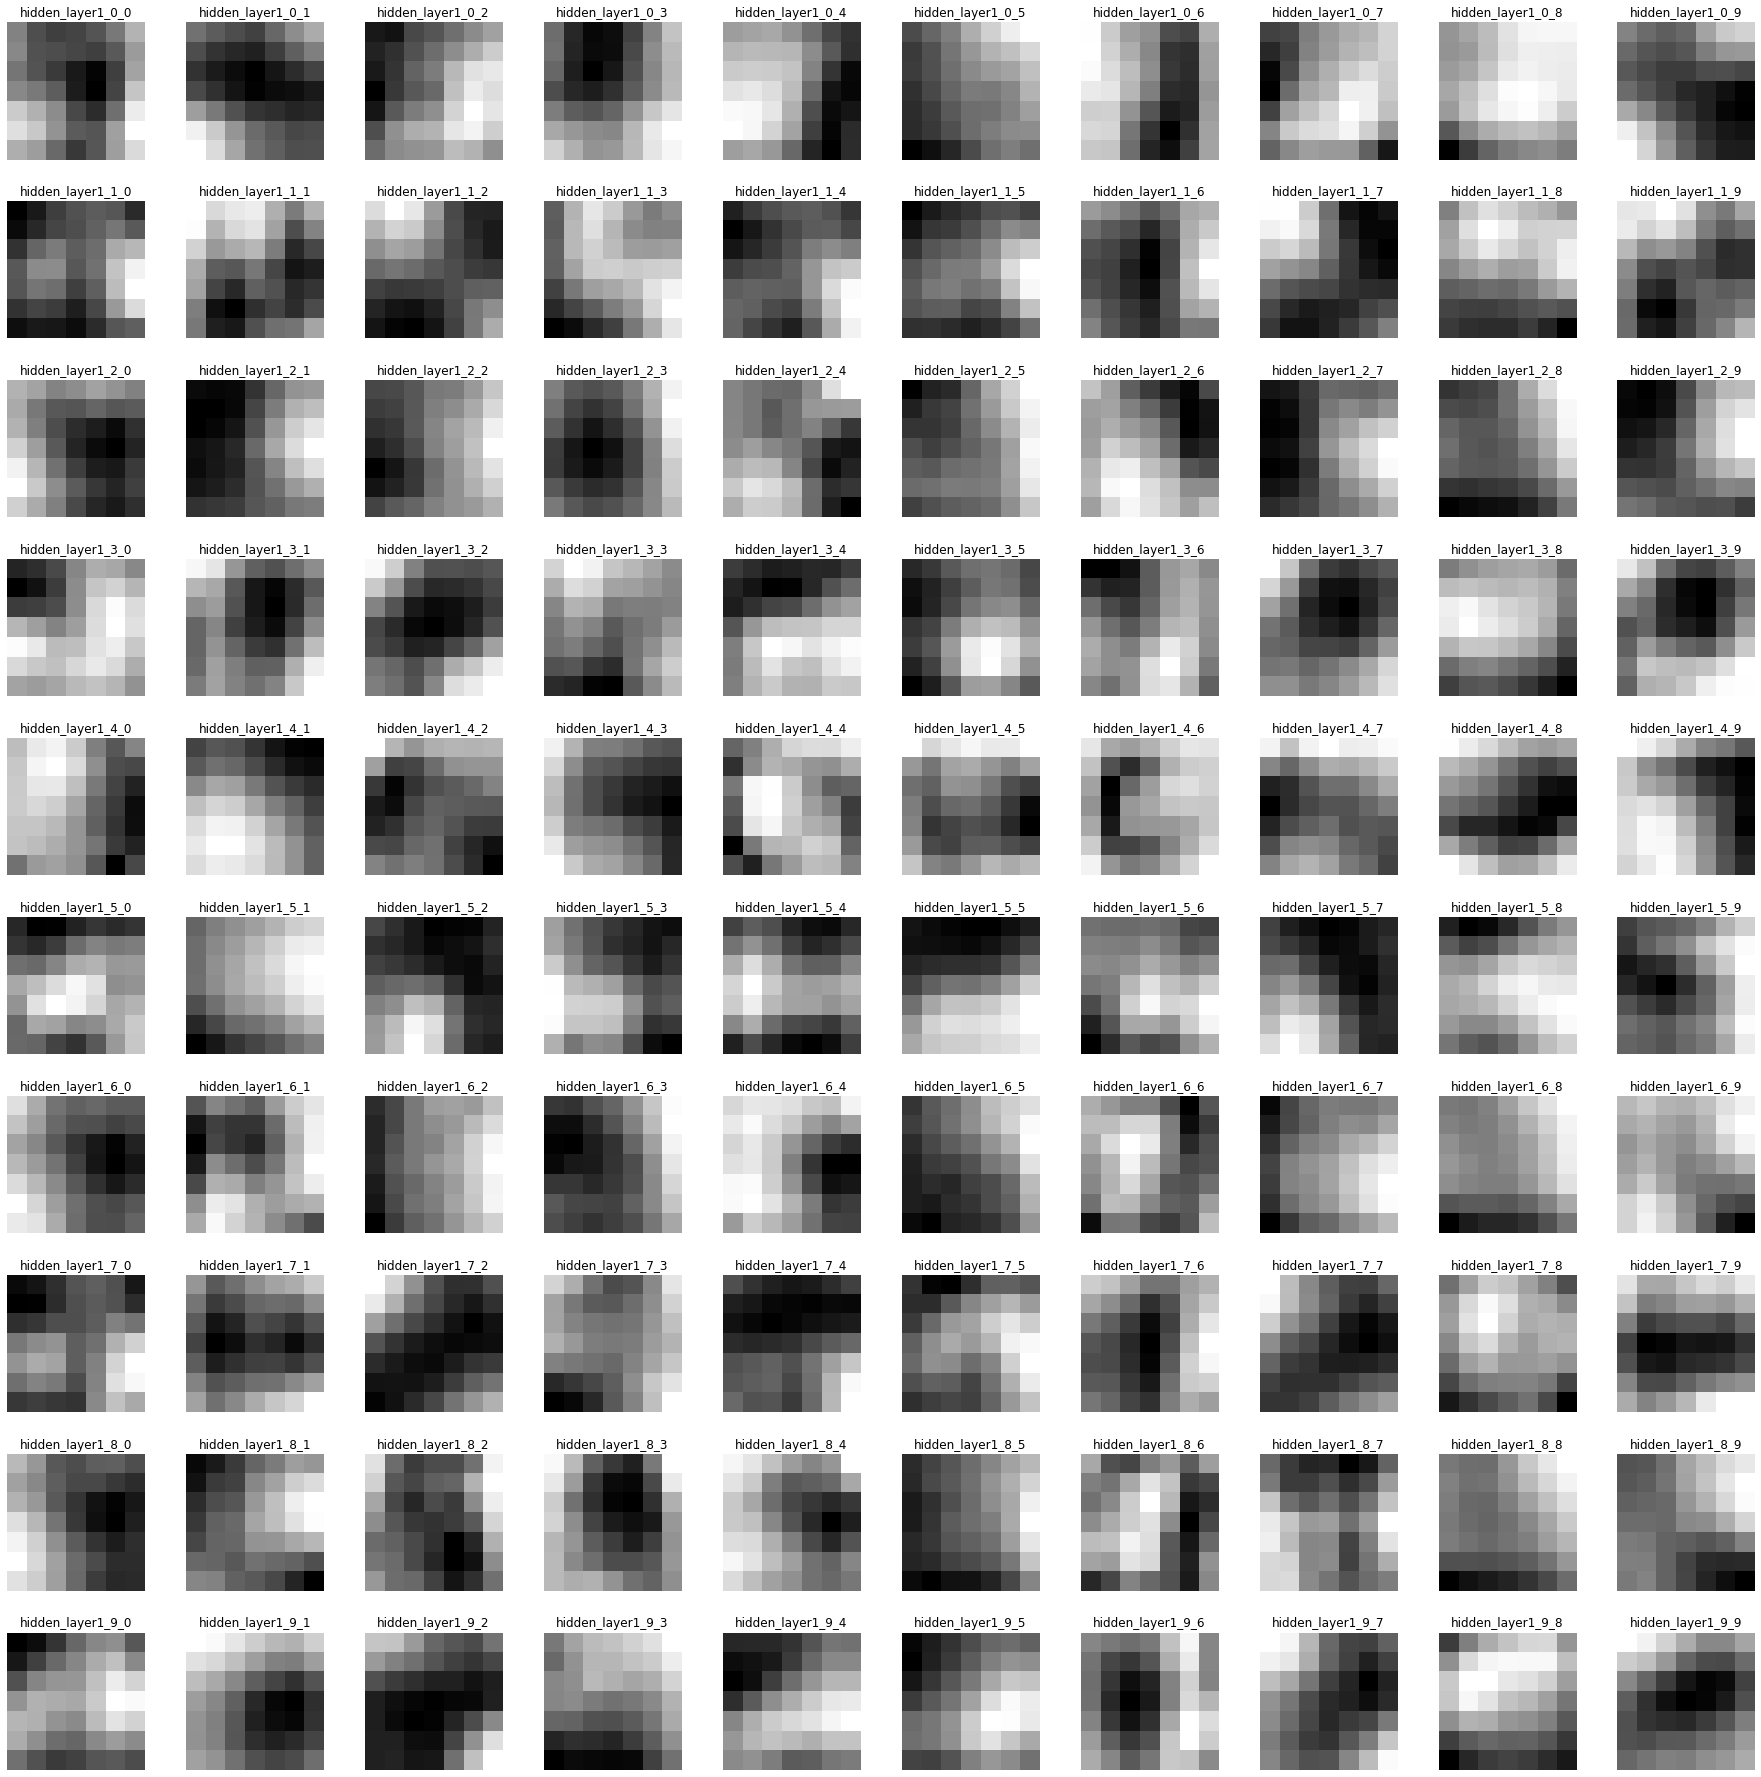

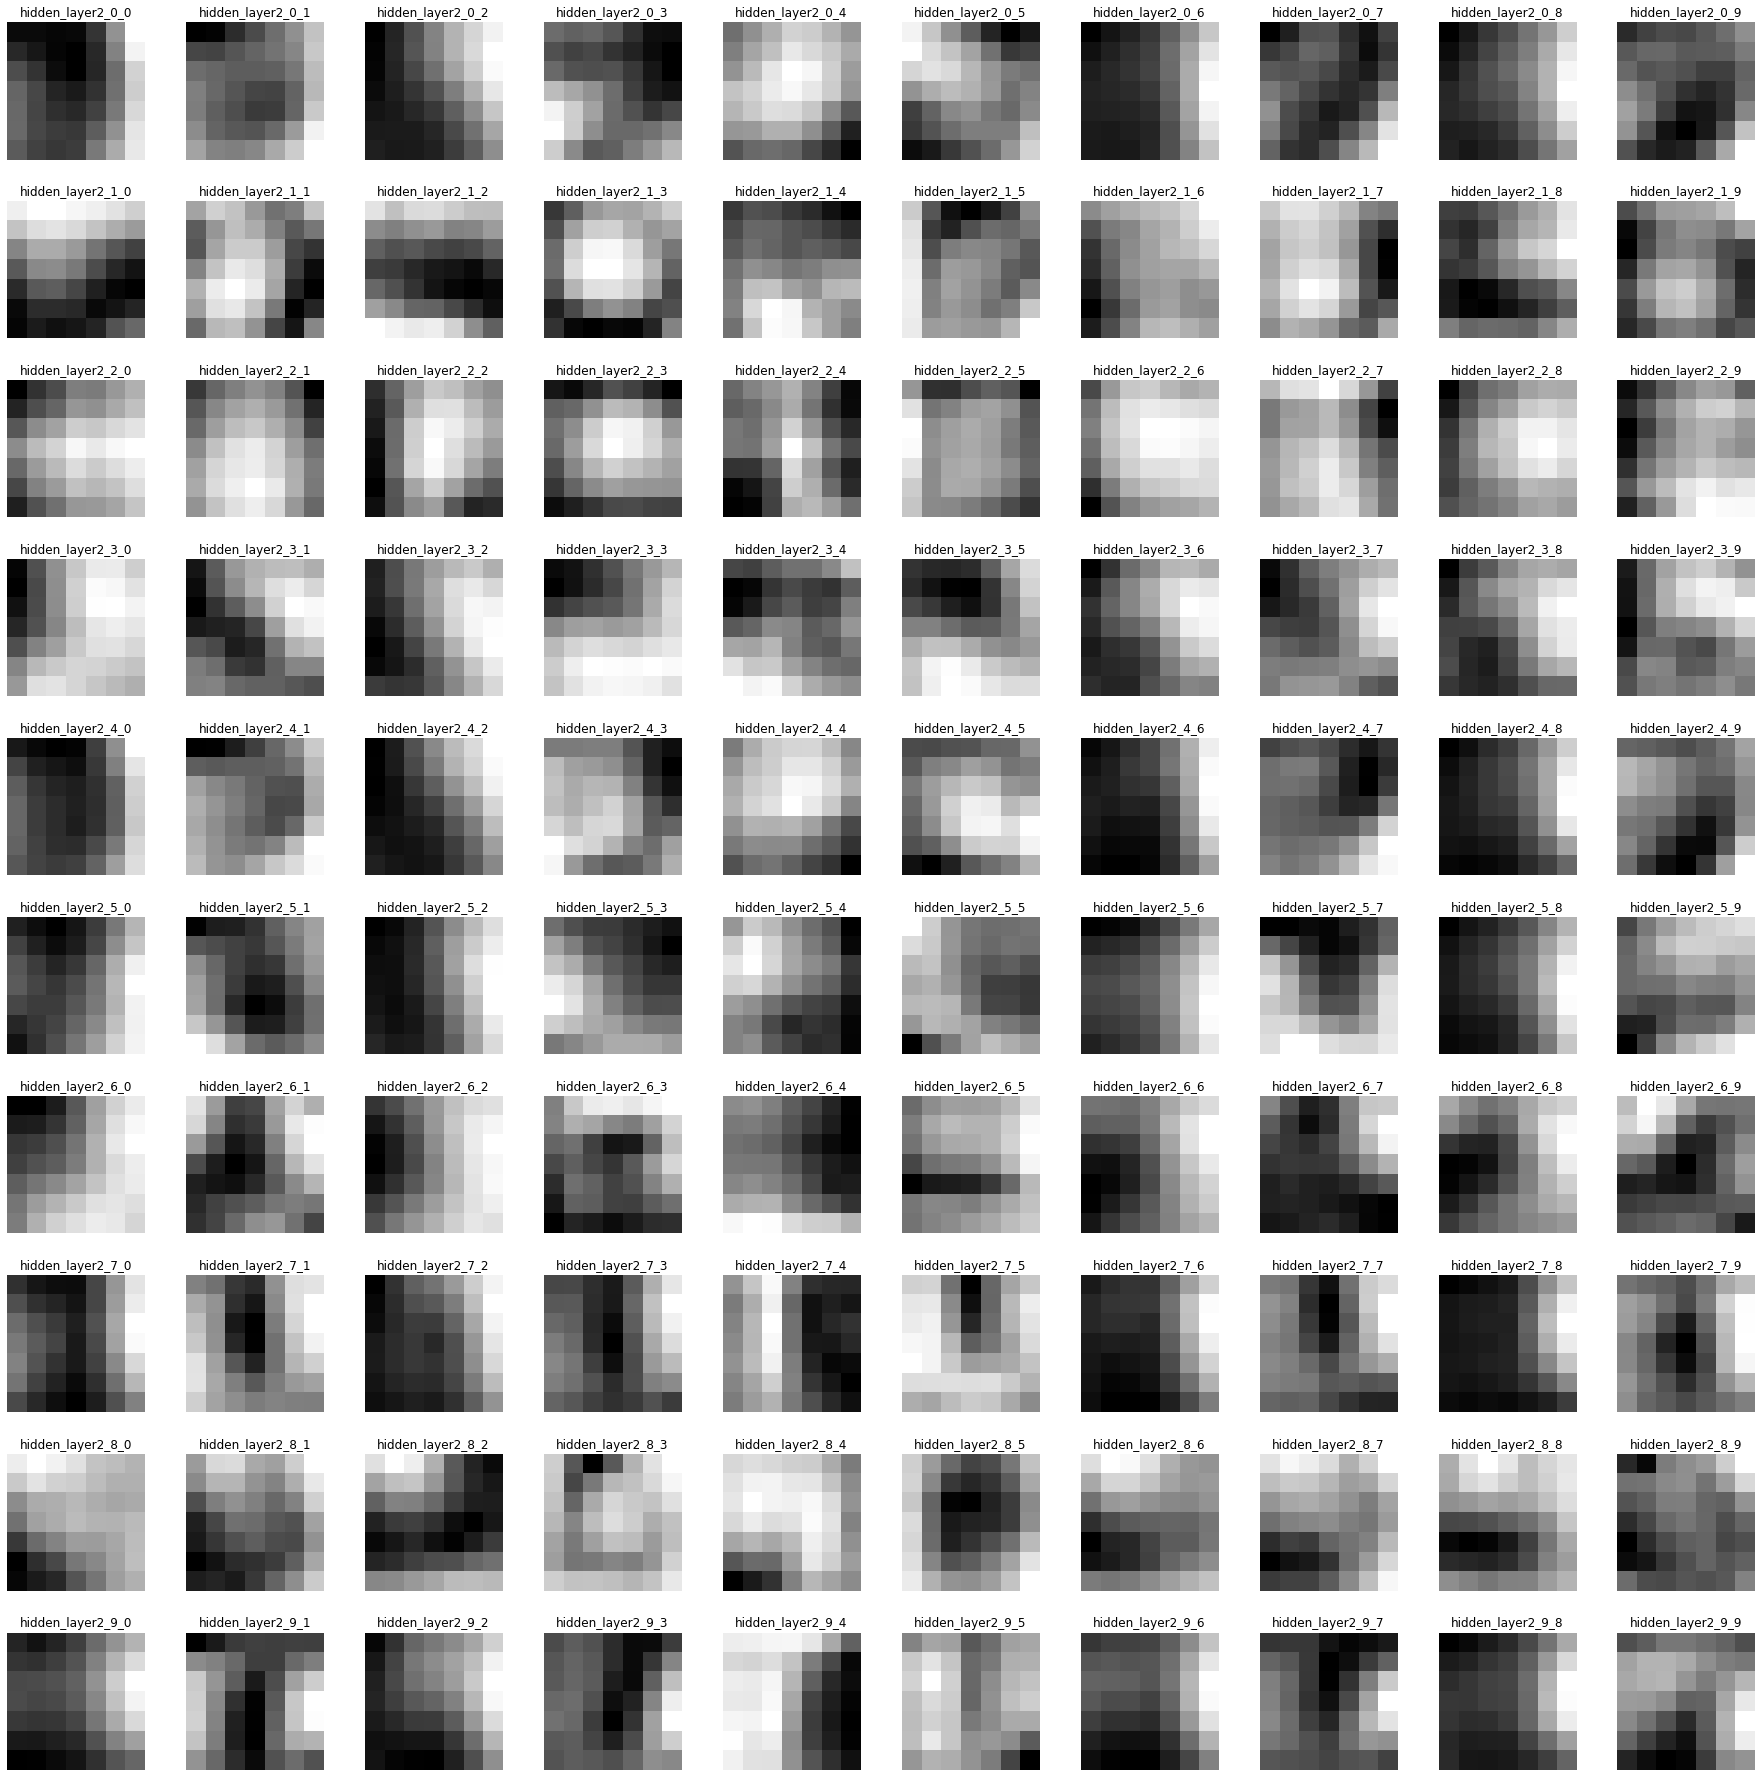

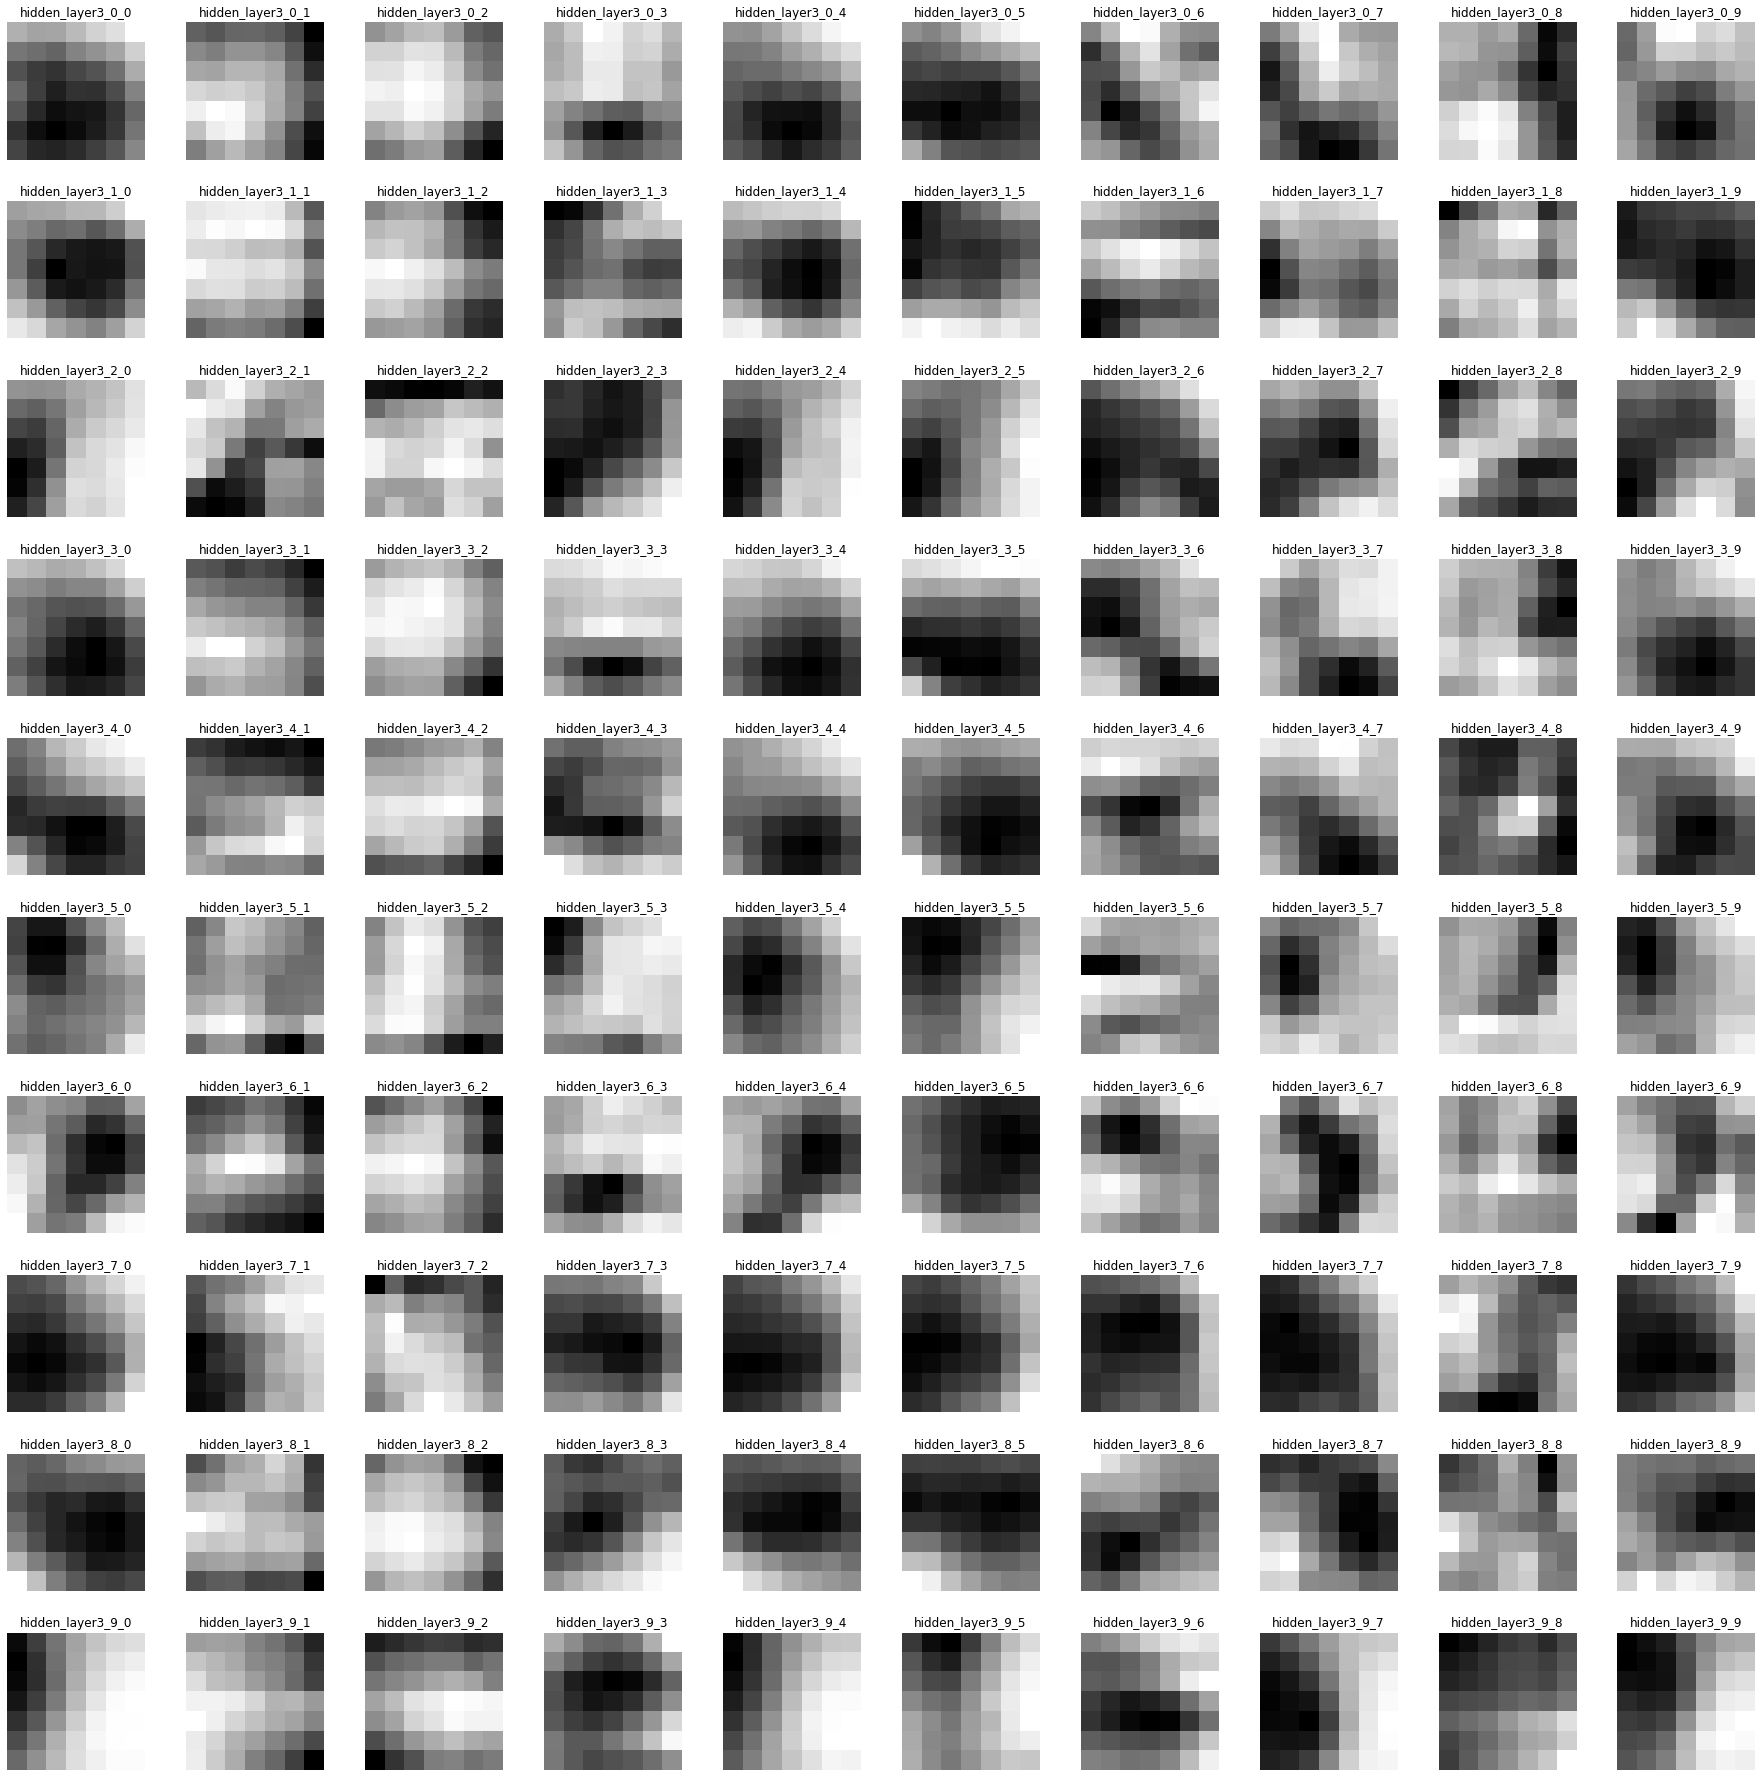

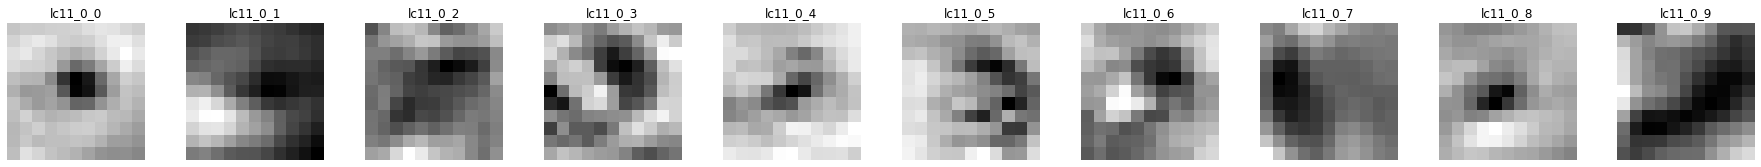

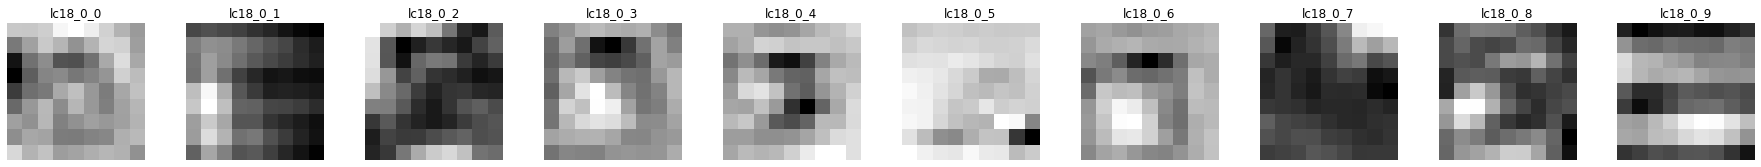

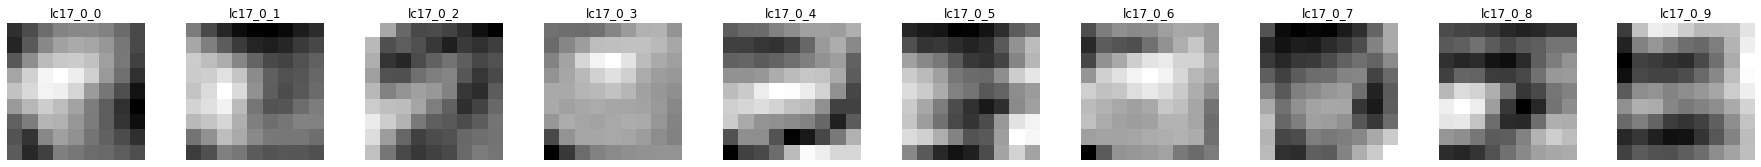

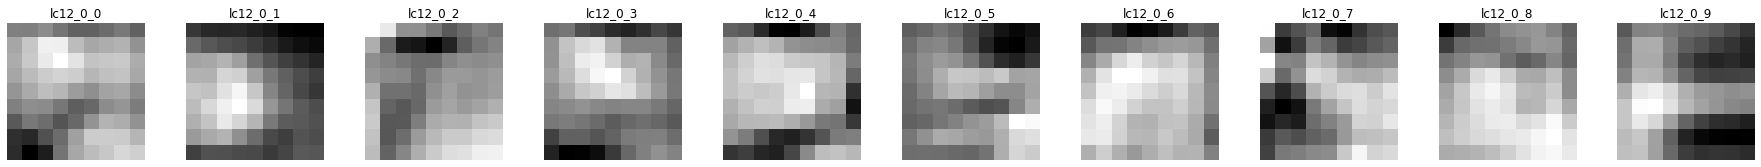

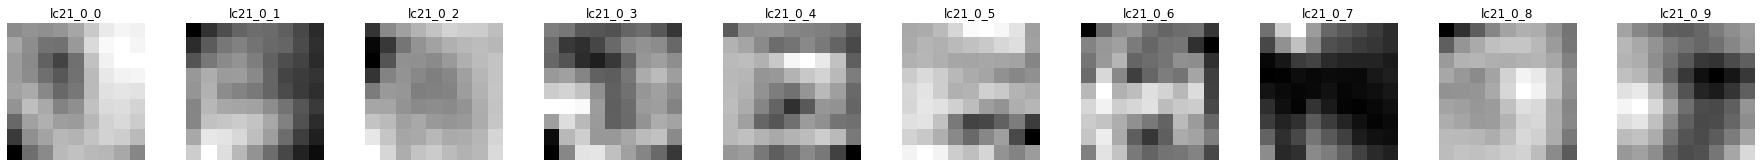

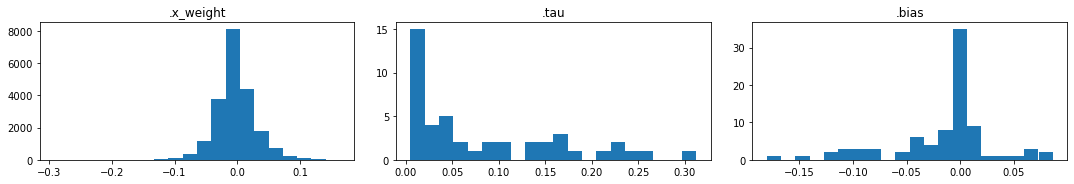

In [15]:
idx_ar = np.arange(0,len(chkpnt_fnames),step_size)
idx_ar = np.append(idx_ar, -1) # add the last saved checkpoint to list

# load and plot each model checkpoint in list
for k in idx_ar:
    checkpoint = torch.load(model_dir / chkpnt_fnames[k], map_location=my_device)
    model.load_state_dict( checkpoint['model'] )

    out_fname_prefix = chkpnt_fnames[k][:-3]
    
    plot_spatial_kernels(model.network, output_dir, out_fname_prefix)
    
    plot_spatial_kernels(model.lc_layers, output_dir, out_fname_prefix)
    
    plot_weight_hist(model, ptn_match, output_dir, out_fname_prefix, num_bins)
    
    